In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
import os
from processing_funcs import *
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Conv1D, MaxPooling1D, Conv1DTranspose
from tensorflow.python.keras.regularizers import l2

2024-11-23 19:54:35.089684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-23 19:54:35.211149: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 19:54:35.217077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-23 19:54:35.217091: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [8]:
# Load dataframe
df = pd.read_parquet("processed_df.parquet")

In [9]:
# Prepare samples
from sklearn.model_selection import train_test_split

# Split into train (70%) and temp (30%) with stratification
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['species'],  # Stratify based on the 'species' column
    random_state=42
)

# Split temp into test (15%) and validation (15%)
test_df, val_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['species'],  # Stratify again to maintain balance
    random_state=42
)

In [10]:
train = np.stack(train_df['scaled spectrum'].to_numpy())
test = np.stack(test_df['scaled spectrum'].to_numpy())
val = np.stack(val_df['scaled spectrum'].to_numpy())

# Add the features dimension to make the data compatible with Conv1D
train = np.expand_dims(train, axis=-1)  # Shape becomes (samples, time_steps, features)
test = np.expand_dims(test, axis=-1)
val = np.expand_dims(val, axis=-1)

In [78]:
# Define name and lambda for this autoencoder run
lambda_l2="0.00001" # L2 regularization coefficient
kernel_width = 50 # Kernel width for moving average for loss function
exp_multi = 10 # weights are exp(exp_multi*diff_from_avg)
filtersize= 5 # Variable kernel size for Conv1D layers    
AE_type = f"cnn kernel={filtersize} expx{exp_multi} weighted mse kernel={kernel_width} l2={lambda_l2}"
lambda_l2=float(lambda_l2)

In [79]:
# Define AE

# Configuration variables
HLactivation = 'relu'               # Activation for hidden layers
outputactivation = 'sigmoid'        # Activation for output layer                            

# Channel numbers for each Conv1D layer
channel_num1 = 32
channel_num2 = 16
channel_num3 = 8

# Max pooling down/upsampling ratio
MP_ratio = 2


# Create the kernel for the weighted mse
kernel = tf.constant([1 / kernel_width] * kernel_width, dtype=tf.float32)
kernel = tf.reshape(kernel, (kernel_width, 1, 1))  # Shape for tf.nn.conv1d (width, in_channels, out_channels)

# Define custom weighted loss function (weights peaks higher)
def weighted_mse(kernel):
    """
    Custom MSE loss function.
    Args:
        y_true: Ground truth values (batch_size, num_bins).
        y_pred: Predicted values (batch_size, num_bins).
        kernel: Moving average kernel
    Returns:
        Mean Squared Error between y_true and y_pred, with weights proportional to the height of the bin compared to its surrounding bins.
    """
    def loss_fn(y_true, y_pred):
        
        # Apply conv1d for moving average
        y_true_expanded = tf.expand_dims(y_true, axis=-1)  # Add channel dimension for convolution
        y_true_avg = tf.nn.conv1d(y_true_expanded, kernel, stride=1, padding='SAME')
        y_true_avg = tf.squeeze(y_true_avg, axis=-1)  # Remove channel dimension after convolution
        
        # we want this to be large on peaks, 1 otherwise. If a bin is above the average, we do exp(diff), otherwise, we just do exp(0)=1.
        diff = tf.maximum(y_true - y_true_avg, 0.0)  # Element-wise max operation
        weights = tf.exp(exp_multi*diff)  # Exponential of the result
        loss = tf.reduce_mean(tf.square(y_true - y_pred)*weights)
        
        return loss
        
    return loss_fn

# Define the encoder
input_data = Input(shape=(train.shape[1],1))
regularizer = l2(lambda_l2)

# Encoder with variable channel numbers
x = Conv1D(channel_num1, filtersize, activation=HLactivation, padding='same', kernel_regularizer=regularizer)(input_data)
x = MaxPooling1D(MP_ratio, padding='same')(x)
x = Conv1D(channel_num2, filtersize, activation=HLactivation, padding='same', kernel_regularizer=regularizer)(x)
x = MaxPooling1D(MP_ratio, padding='same')(x)
x = Conv1D(channel_num3, filtersize, activation=HLactivation, padding='same', kernel_regularizer=regularizer)(x)
encoded = MaxPooling1D(MP_ratio, padding='same')(x)

# Decoder with variable channel numbers
x = Conv1DTranspose(channel_num3, filtersize, strides=MP_ratio, activation=HLactivation, padding='same', kernel_regularizer=regularizer)(encoded)
x = Conv1DTranspose(channel_num2, filtersize, strides=MP_ratio, activation=HLactivation, padding='same', kernel_regularizer=regularizer)(x)
x = Conv1DTranspose(channel_num1, filtersize, strides=MP_ratio, activation=HLactivation, padding='same', kernel_regularizer=regularizer)(x)

decoded = Conv1D(1, filtersize, activation=outputactivation, padding='same')(x)

# Define the autoencoder model
autoencoder = Model(input_data, decoded)

# Compile the model using the weighted loss function
autoencoder.compile(optimizer='adam', loss=weighted_mse(kernel))

# Print a summary of the model to verify the architecture
autoencoder.summary()


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 8192, 1)]         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 8192, 32)          192       
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 4096, 32)          0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 4096, 16)          2576      
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 2048, 16)          0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 2048, 8)           648       
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 1024, 8)           0  

In [ ]:
# Train AE

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define batch size, number of epochs, and patience
batch_size = 32
epochs = 15
patience = 3

weight_path=os.path.join("AE Weights", f"{AE_type}.h5")


# Add callbacks for better training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),  # Stop if no improvement for 5 epochs
    ModelCheckpoint(weight_path, save_best_only=True, monitor='val_loss')  # Save the best model
]

# Train the model
history = autoencoder.fit(
    train,                # Training data
    train,                # Target is same as input for autoencoder
    validation_data=(val, val),  # Validation data
    epochs=epochs,        # Number of epochs
    batch_size=batch_size,  # Batch size
    callbacks=callbacks,    # Add callbacks for early stopping and checkpointing
    verbose=1               # Verbose output
)

# Evaluate the model on the test set
test_loss = autoencoder.evaluate(test, test, verbose=1)  # Verbose output for evaluation

print("Test Loss:", test_loss)


Epoch 1/15
84/84 [==============================] - 14s 164ms/step - loss: 2.4092 - val_loss: 1.3587
Epoch 2/15
84/84 [==============================] - 13s 158ms/step - loss: 0.9074 - val_loss: 0.5966
Epoch 3/15
84/84 [==============================] - 13s 161ms/step - loss: 0.5466 - val_loss: 0.5131
Epoch 4/15
84/84 [==============================] - 14s 162ms/step - loss: 0.4971 - val_loss: 0.4798
Epoch 5/15
84/84 [==============================] - 14s 163ms/step - loss: 0.4688 - val_loss: 0.4548
Epoch 6/15
84/84 [==============================] - 14s 164ms/step - loss: 0.4416 - val_loss: 0.4263
Epoch 7/15
62/84 [=====================>........] - ETA: 3s - loss: 0.4187

In [63]:
def plot_ae_samples(AE_type, test_df, save=False):
    weight_path=os.path.join("AE Weights", f"{AE_type}.h5")
    autoencoder.load_weights(weight_path)
    freqs = rfftfreq(32768, 1/44100)[0:8192]
    fig=0
    # make subfolder to save these plots in
    if save:
        os.makedirs(os.path.join("AE Sample Plots", AE_type), exist_ok=True)
    for species in ['Human', 'Lizard', 'Anolis']:
        if species == 'Human':
            r = [2, 9]
        elif species == 'Lizard':
            r = [3, 8]
        else:
            r = [2, 3]
        for i in r:
            fig+=1
            row = test_df[test_df['species']==species].iloc[i]
            # reshape our data to (batch size, spectrum width, 1)
            scaled_spectrum_reshaped = row['scaled spectrum'].reshape(1, -1, 1)
            # get the denoised spectrum from the AE, undo max min scaling
            denoised_spectrum = autoencoder.predict(scaled_spectrum_reshaped)*(row['max']-row['min']) + row['min']
            # reshape from (1, 8192, 1) to (8192,)
            denoised_spectrum = denoised_spectrum.reshape(-1)
            # get the original spectrum (undo max min scaling)
            true_spectrum = row['scaled spectrum']*(row['max']-row['min']) + row['min']
            
            plt.figure(fig, figsize=(12, 5))

            plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot 
            plt.plot(freqs/1000, true_spectrum)
            plt.title(f"Original Spectrum ({species})")
            plt.xlabel("Frequency (kHz)")
            plt.ylabel("dB SPL")
            plt.ylim(np.min(true_spectrum), np.max(true_spectrum))
            
            # Create the second subplot
            plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
            plt.plot(freqs/1000, denoised_spectrum)
            plt.title(f"Denoised Spectrum ({species})")
            plt.xlabel("Frequency (kHz)")
            plt.ylabel("dB SPL")
            plt.ylim(np.min(true_spectrum), np.max(true_spectrum))

            # Add title, adjust layout and show the figure
            plt.suptitle(row['filepath'])
            plt.tight_layout()
            if save:
                file_path = os.path.join("AE Sample Plots", AE_type, f"{row['filepath']} ({AE_type}).png")
                plt.savefig(file_path)
            plt.show()


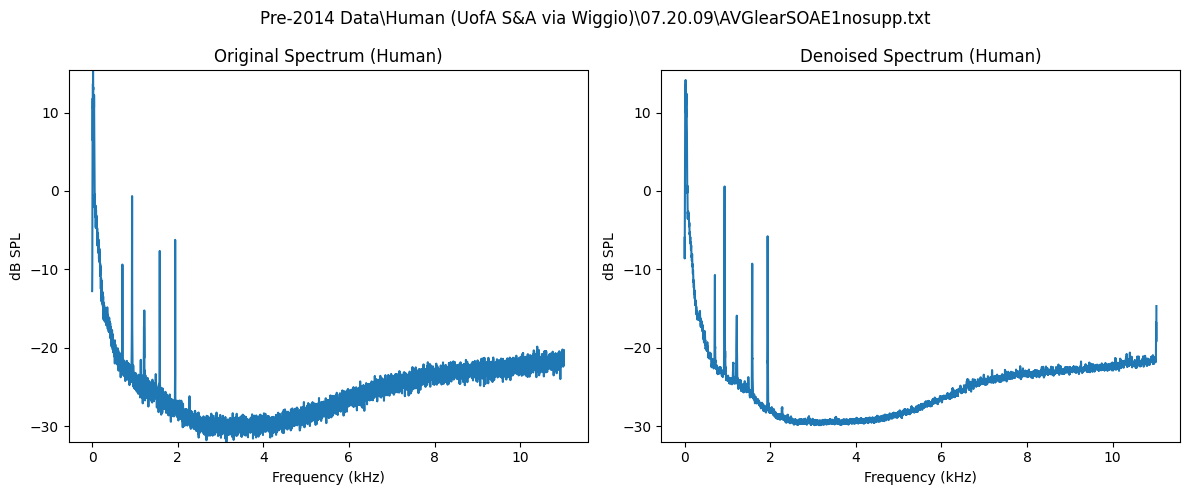

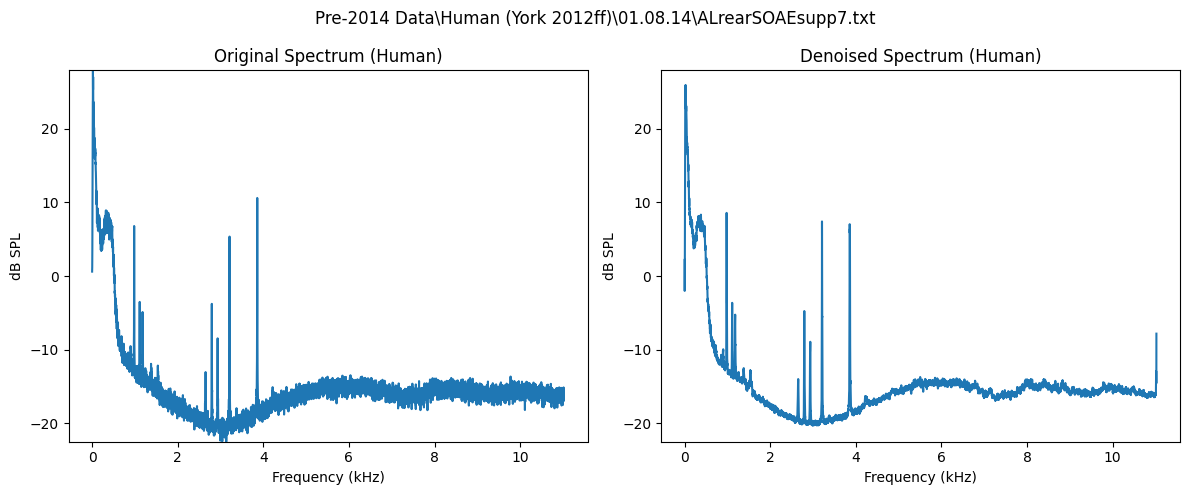

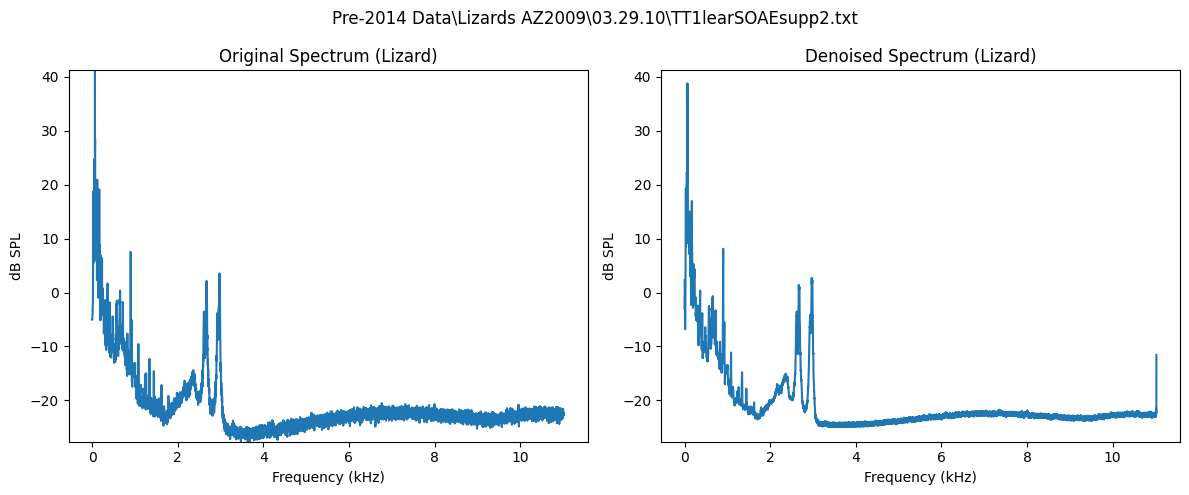

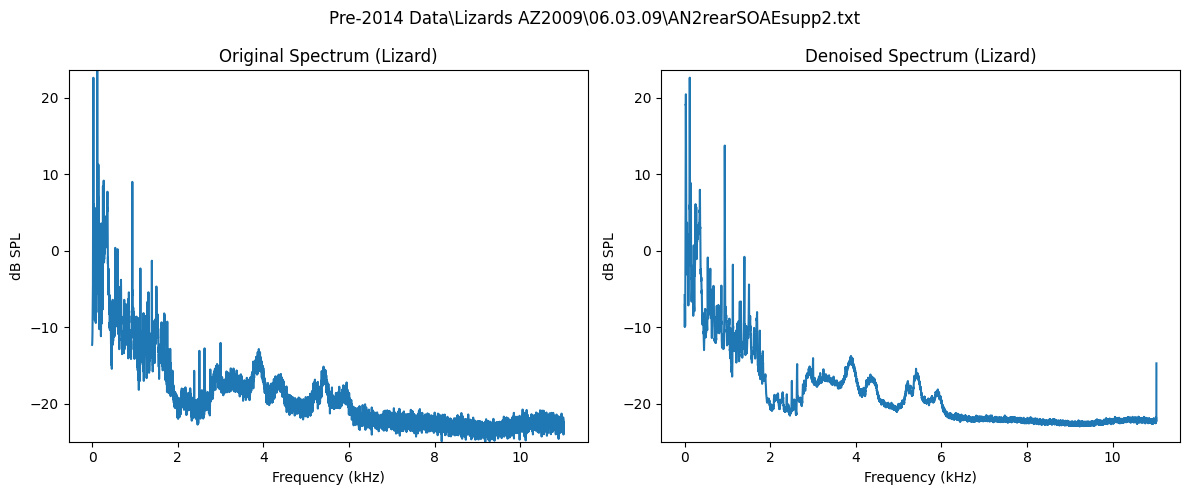

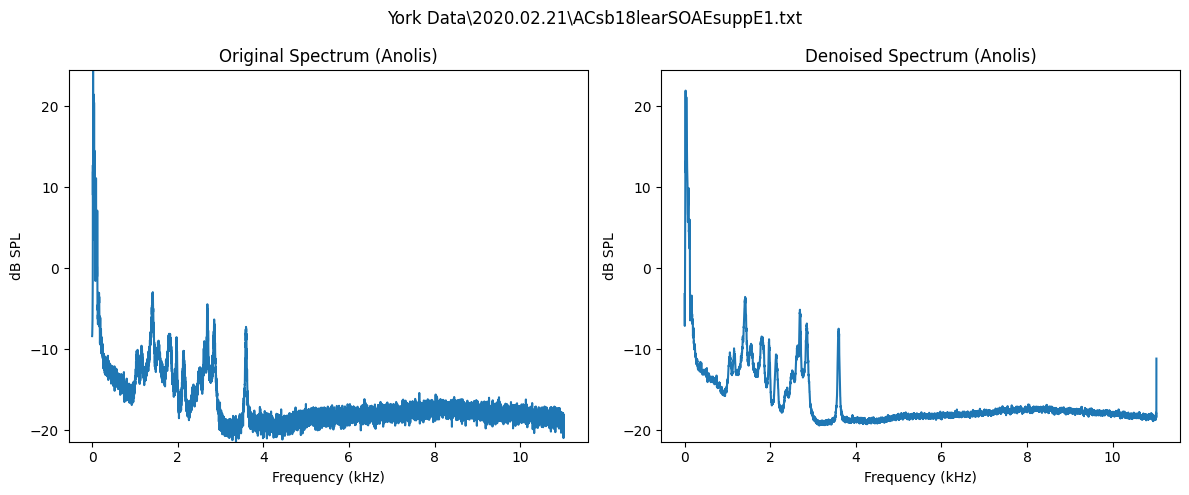

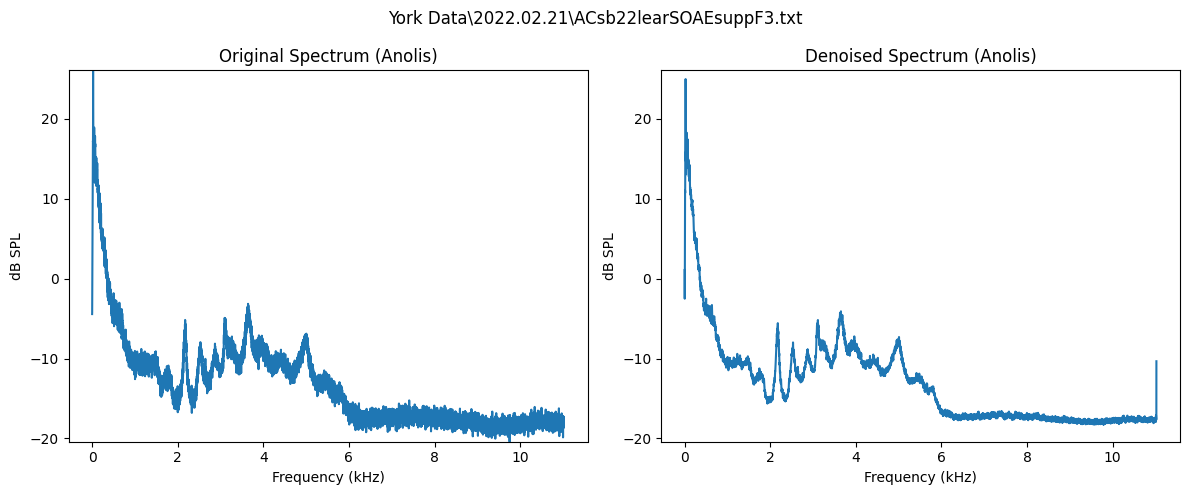

In [71]:
plot_ae_samples("cnn kernel=3 expx10 weighted mse kernel=50 l2=0.00001", test_df, save=True)

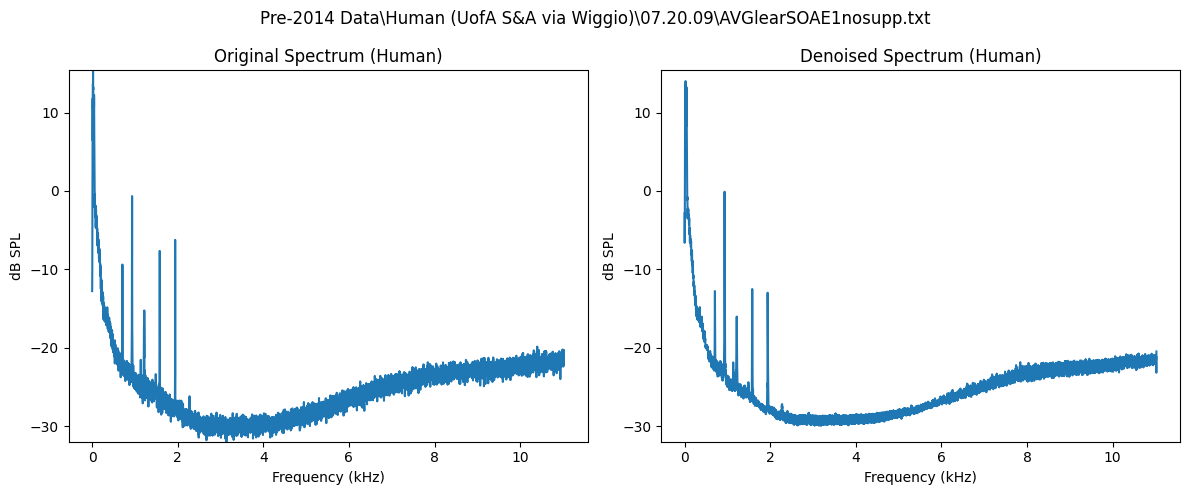

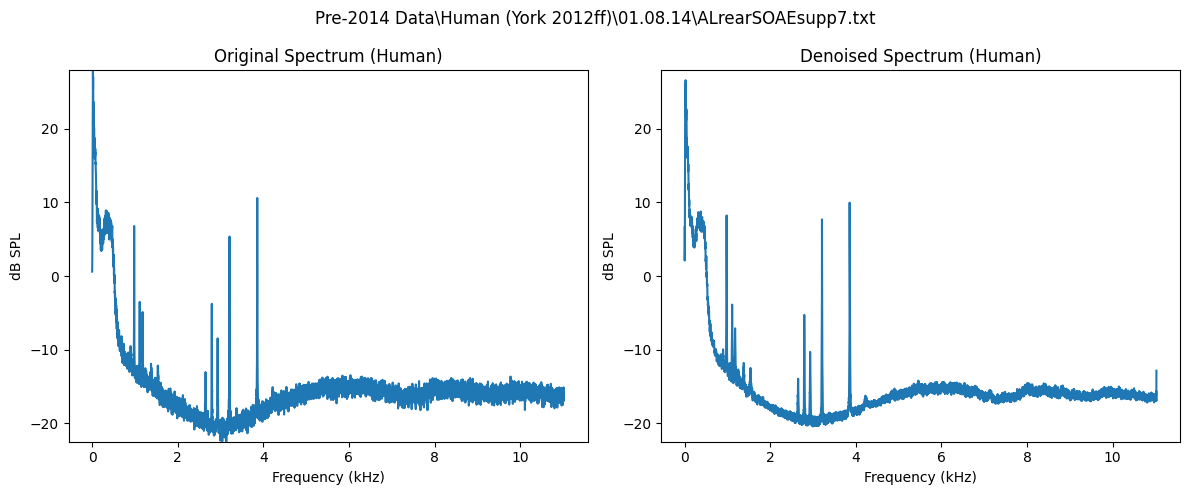

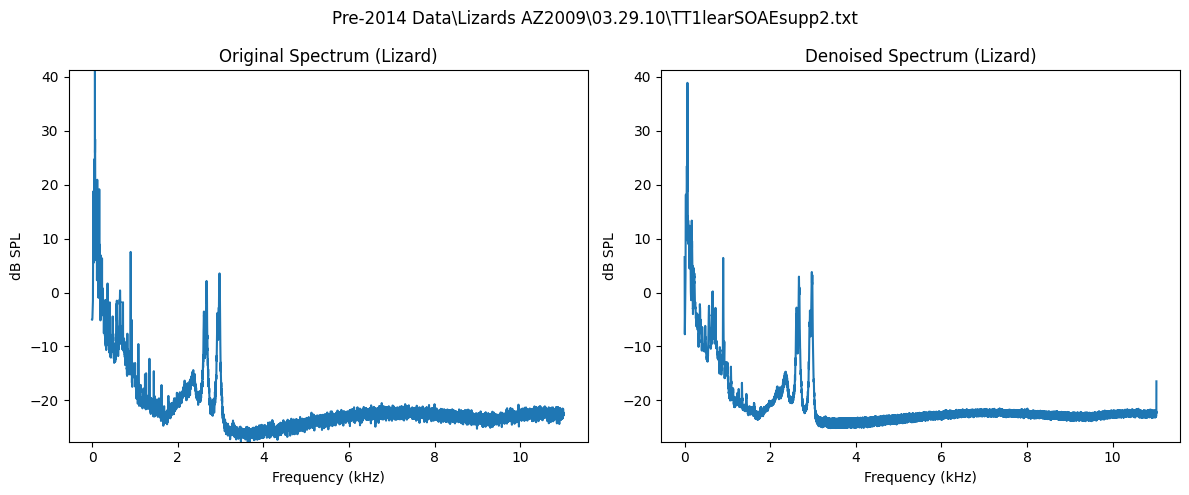

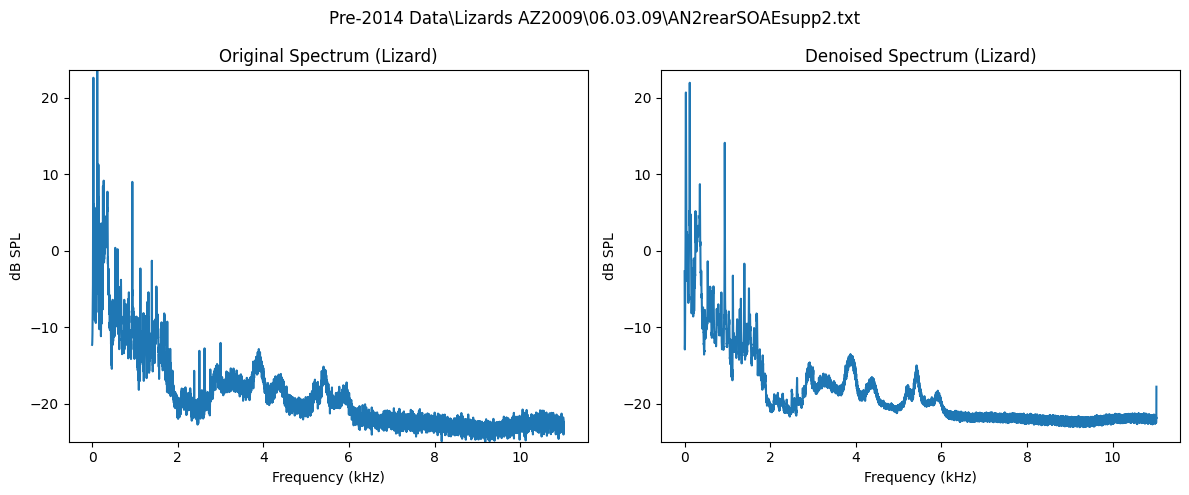

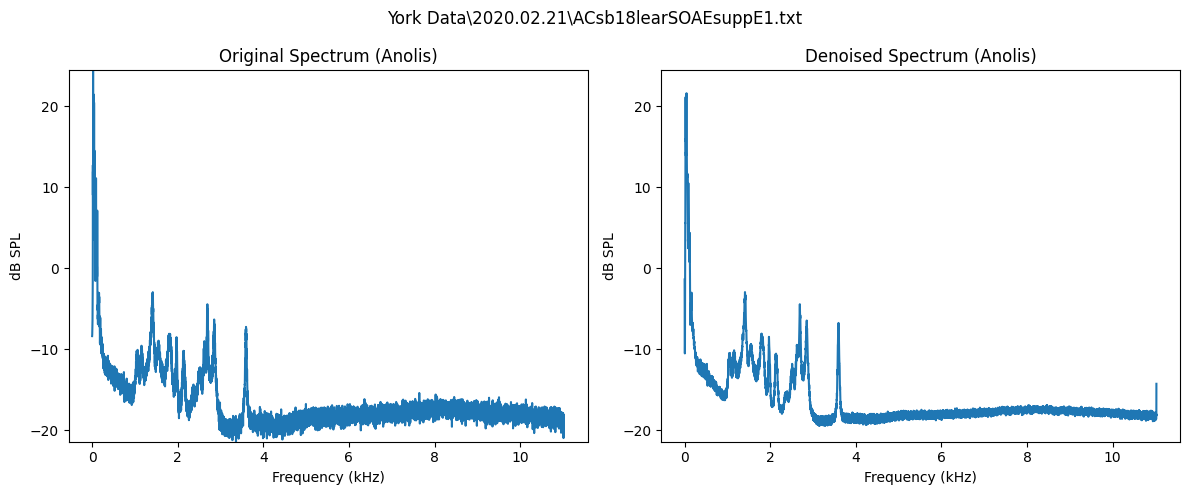

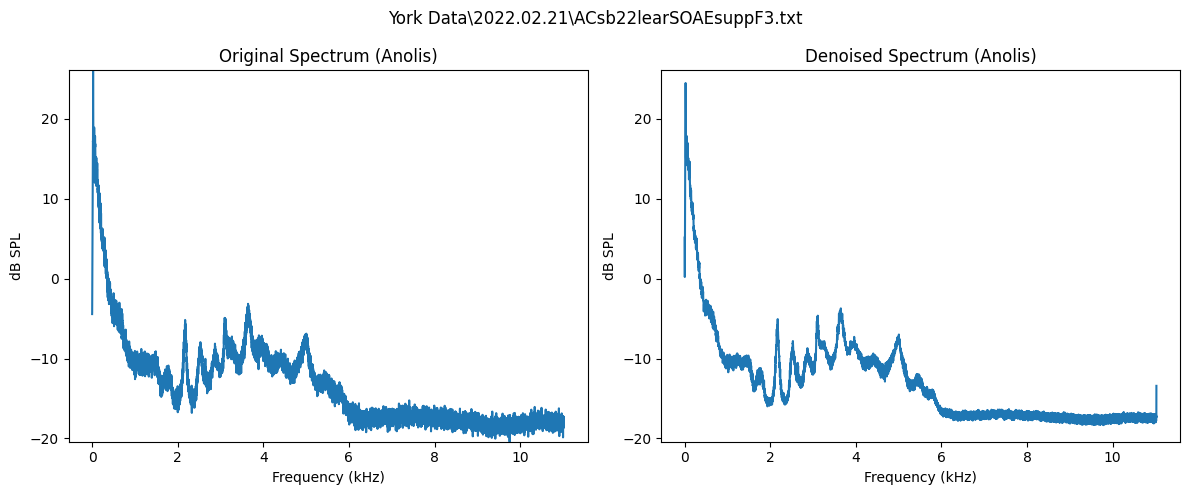

In [72]:
plot_ae_samples("cnn kernel=3 expx10 weighted mse kernel=50 l2=0.0001", test_df, save=True)

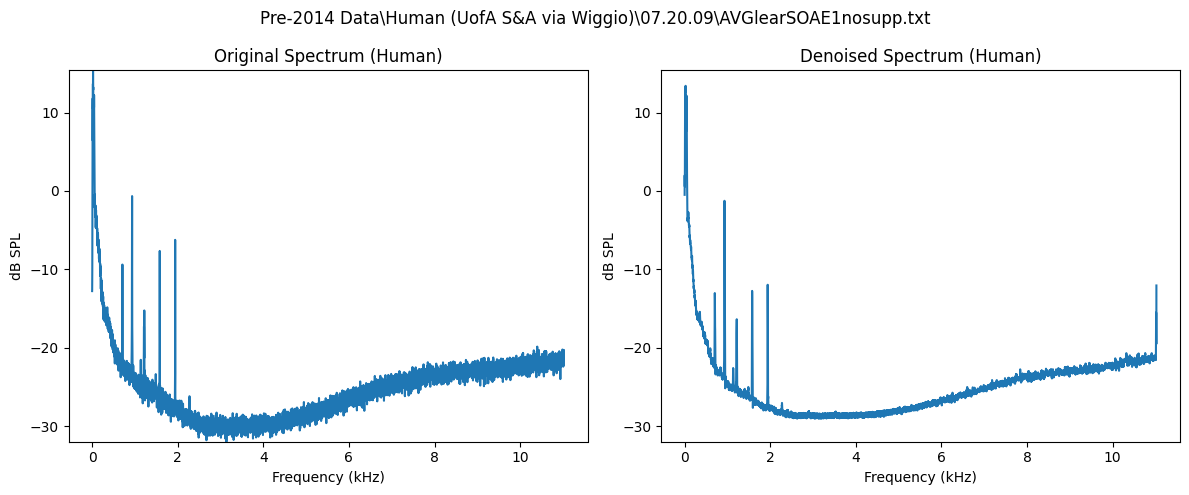

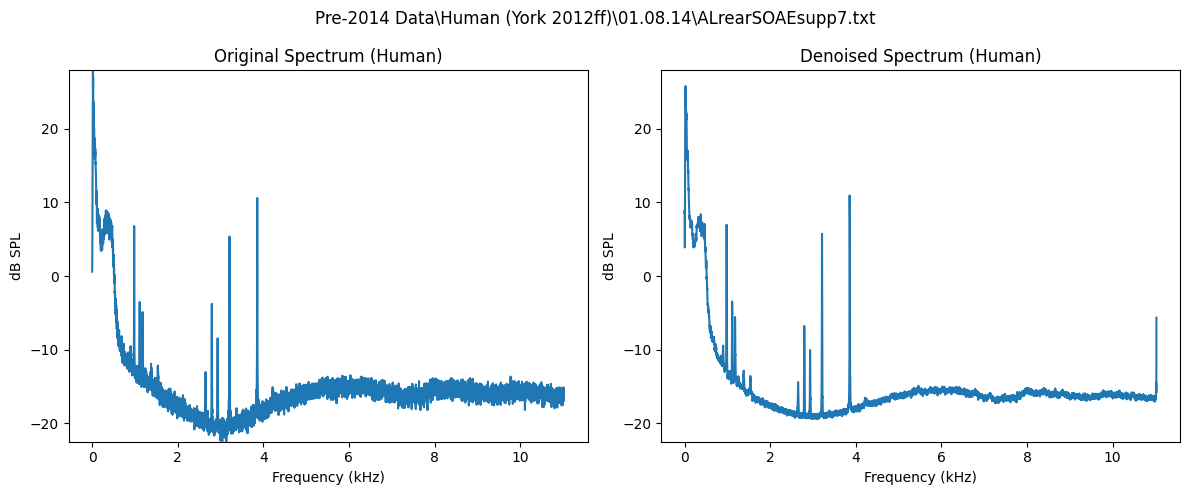

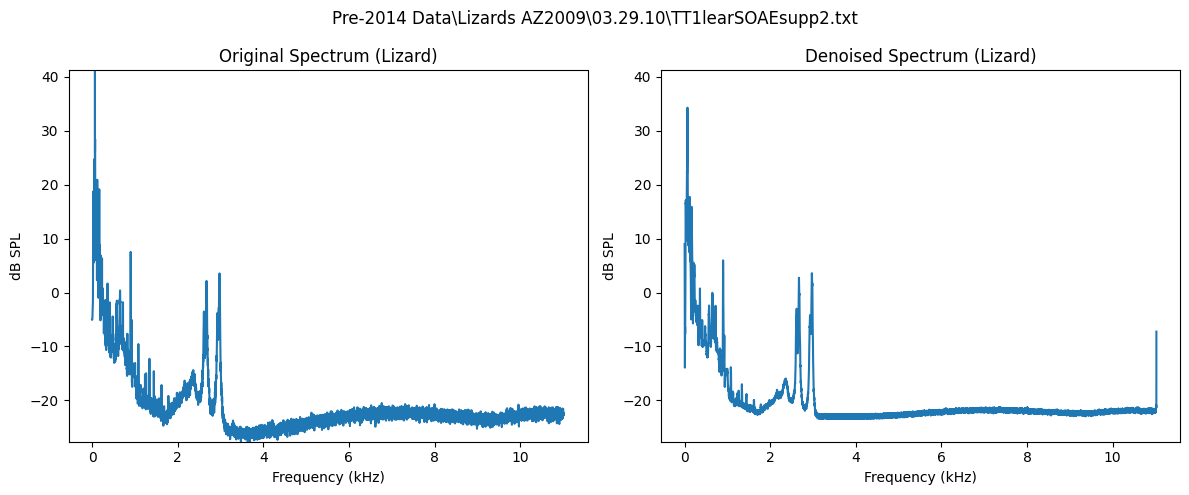

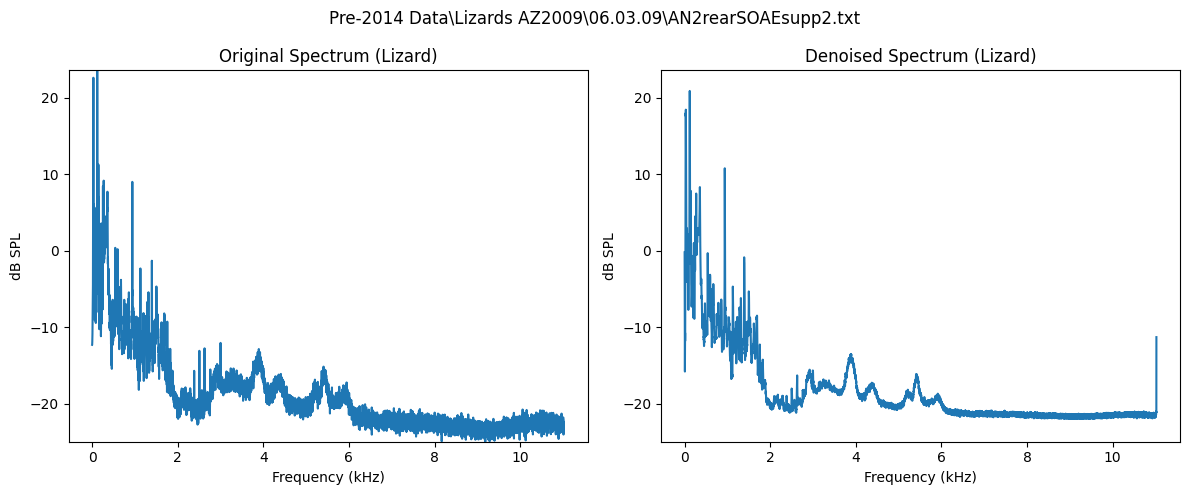

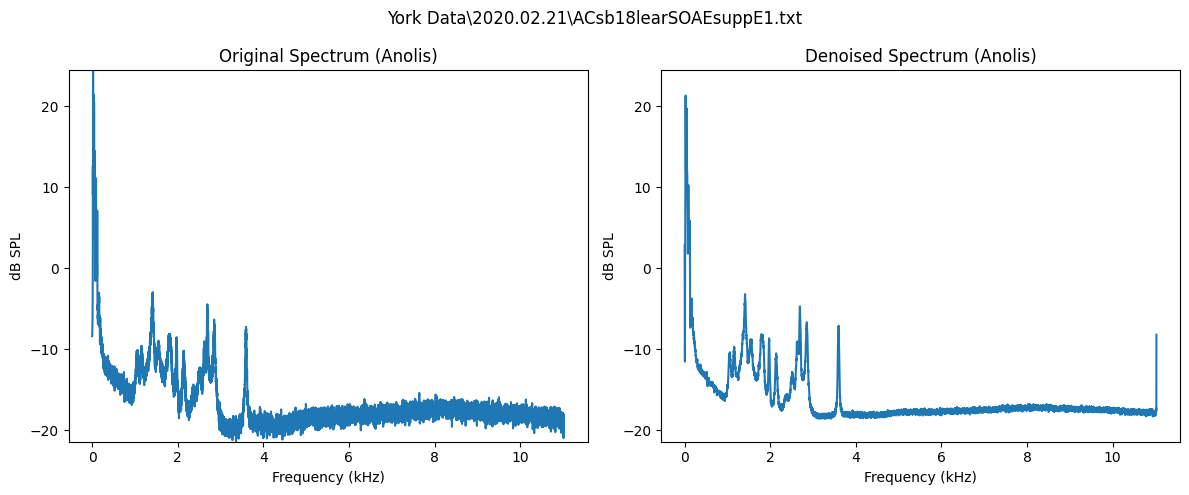

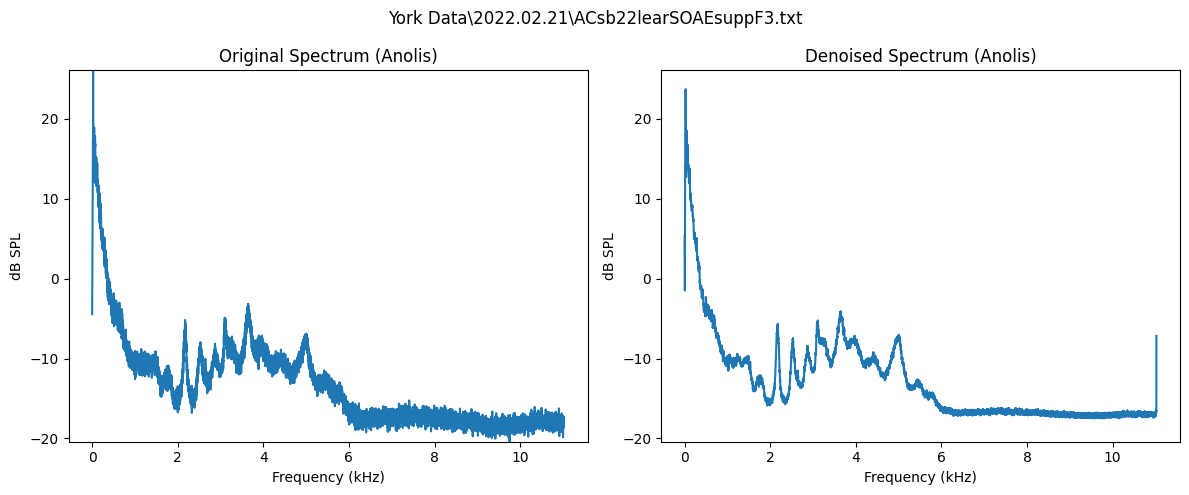

In [73]:
plot_ae_samples("cnn kernel=3 expx10 weighted mse kernel=50 l2=0.001", test_df, save=True)

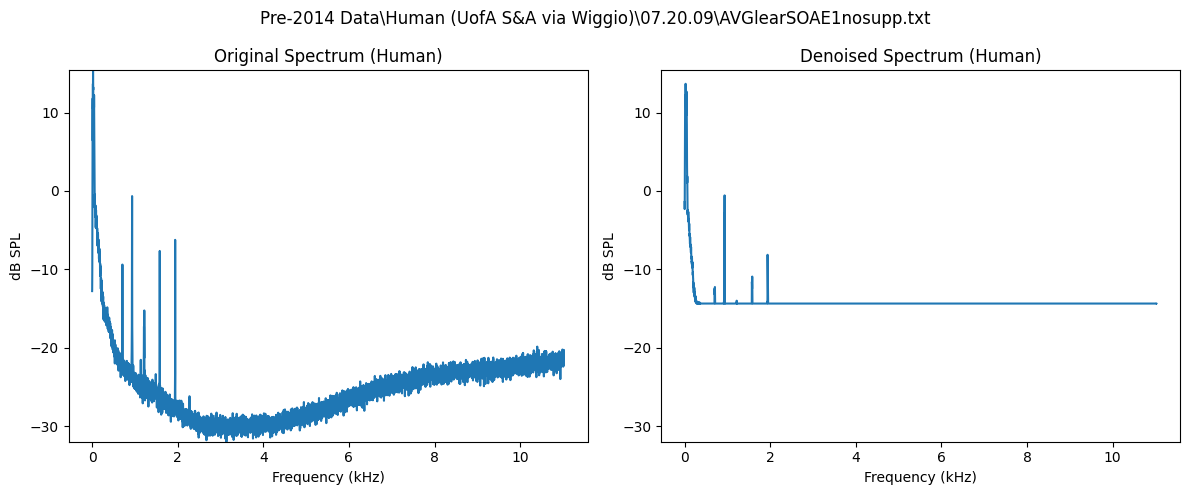

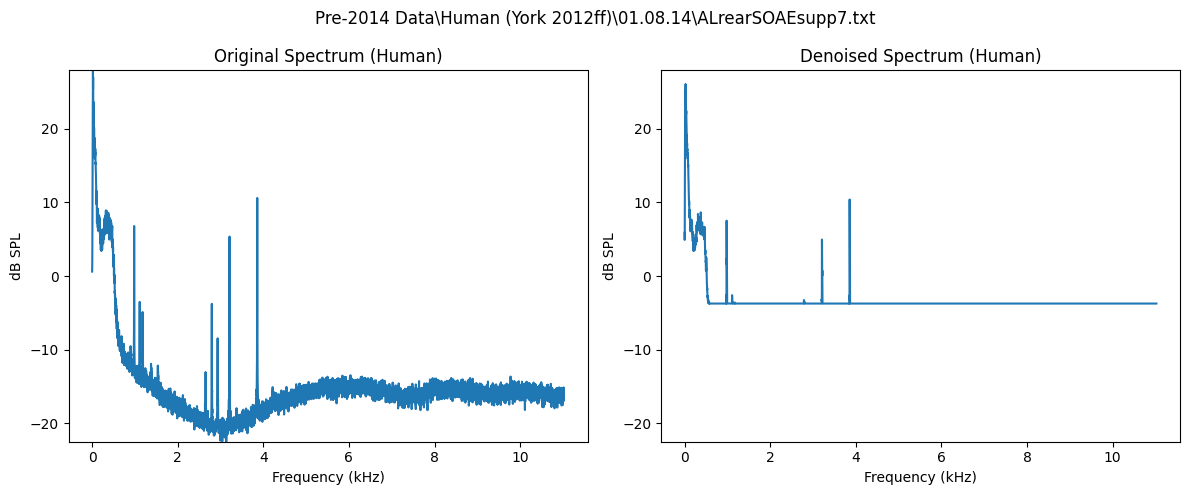

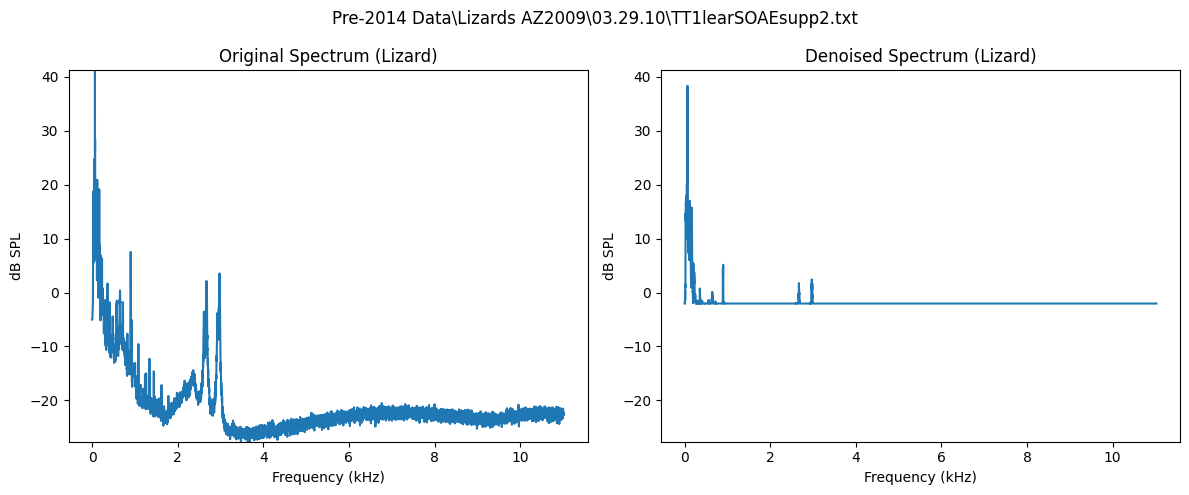

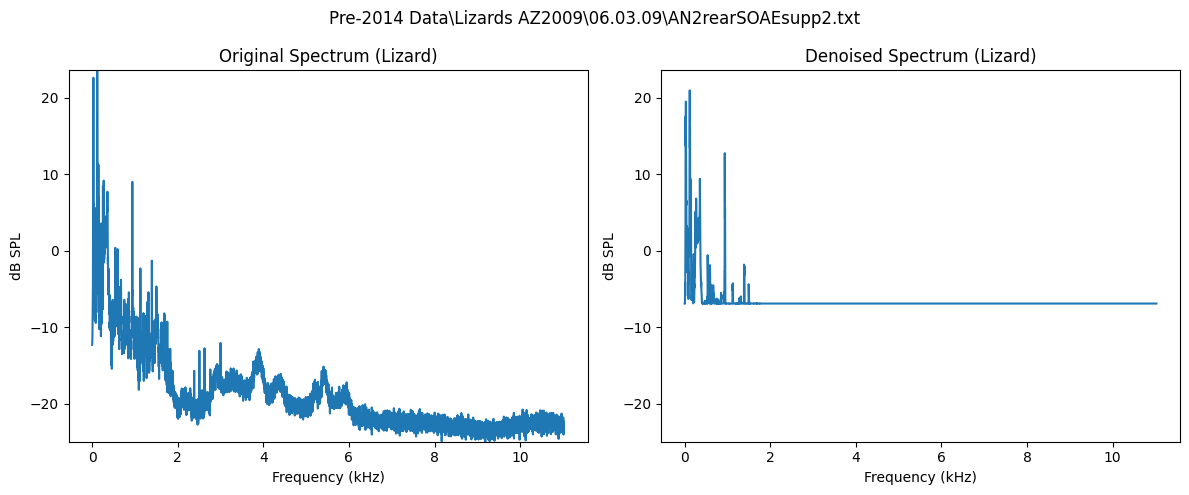

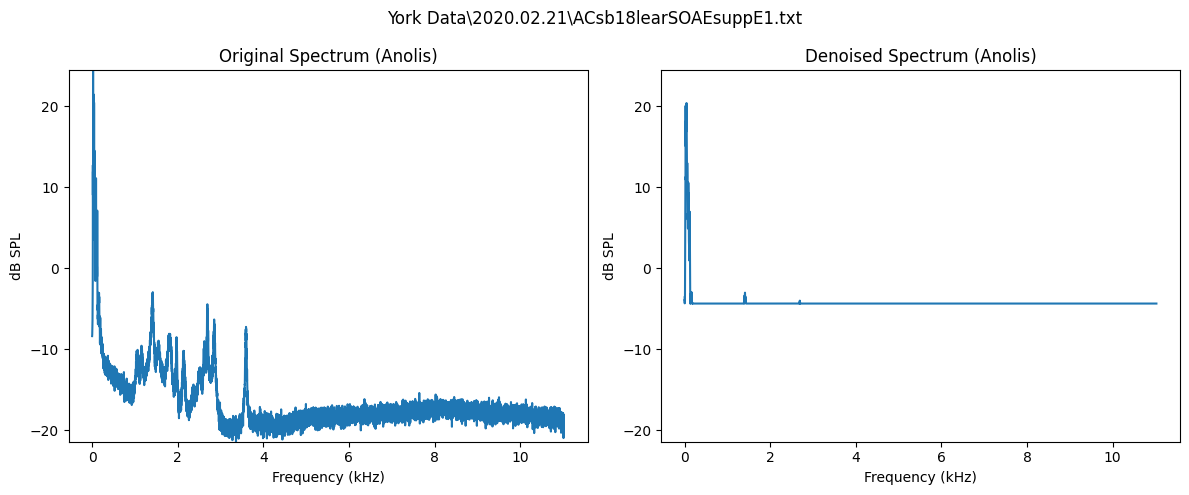

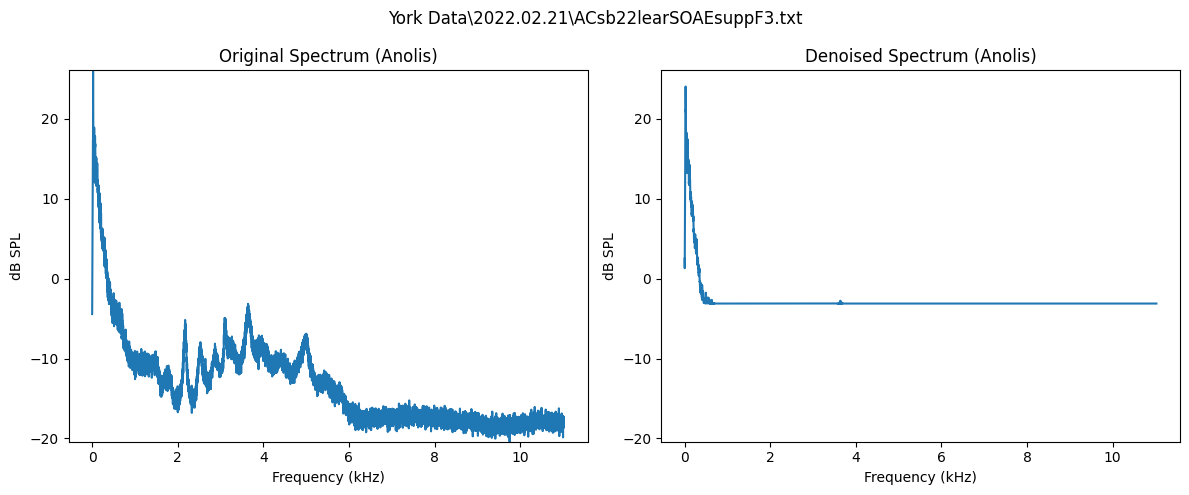

In [77]:
plot_ae_samples("cnn kernel=2 expx10 weighted mse kernel=50 l2=0.00001", test_df, save=True)

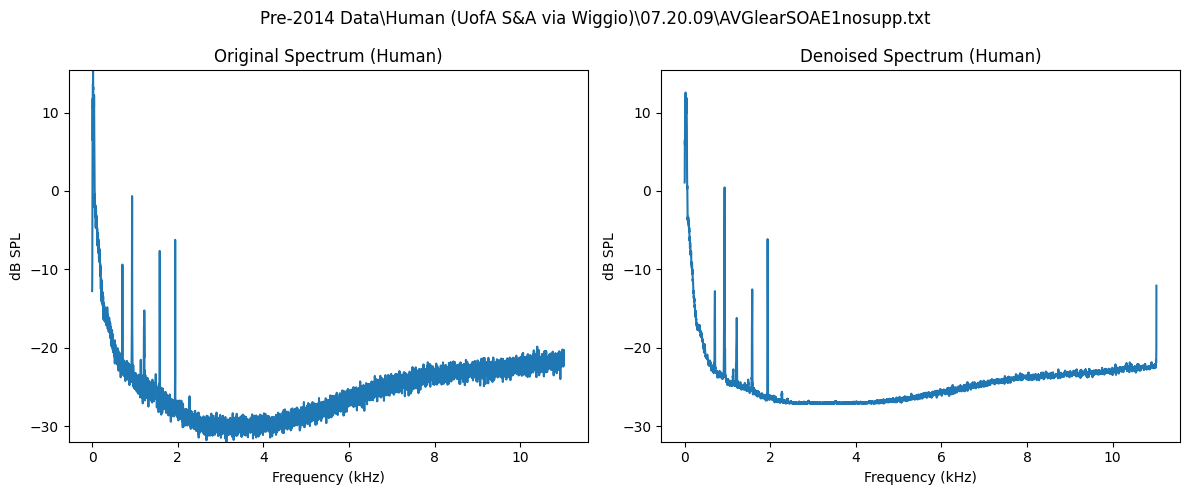

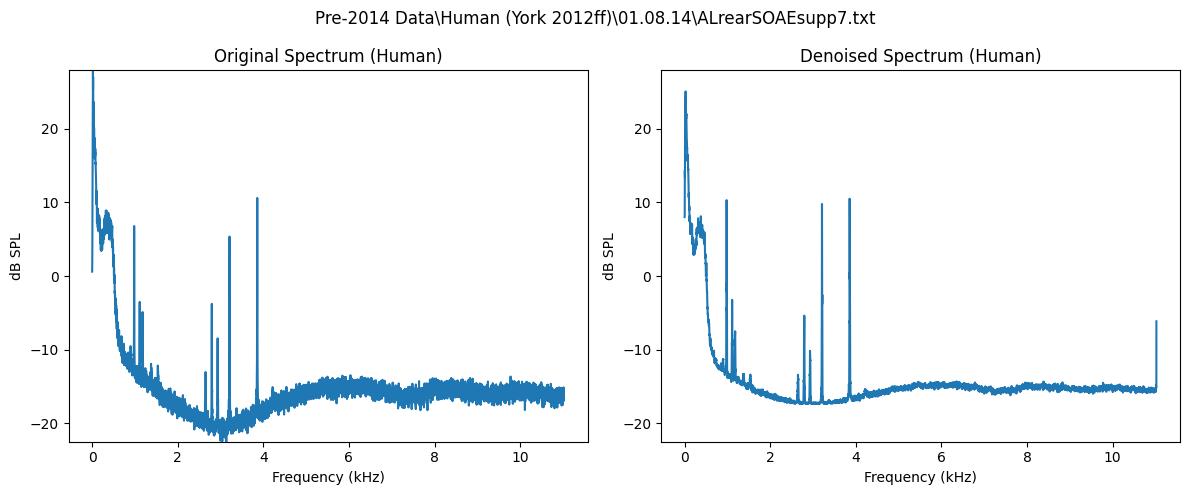

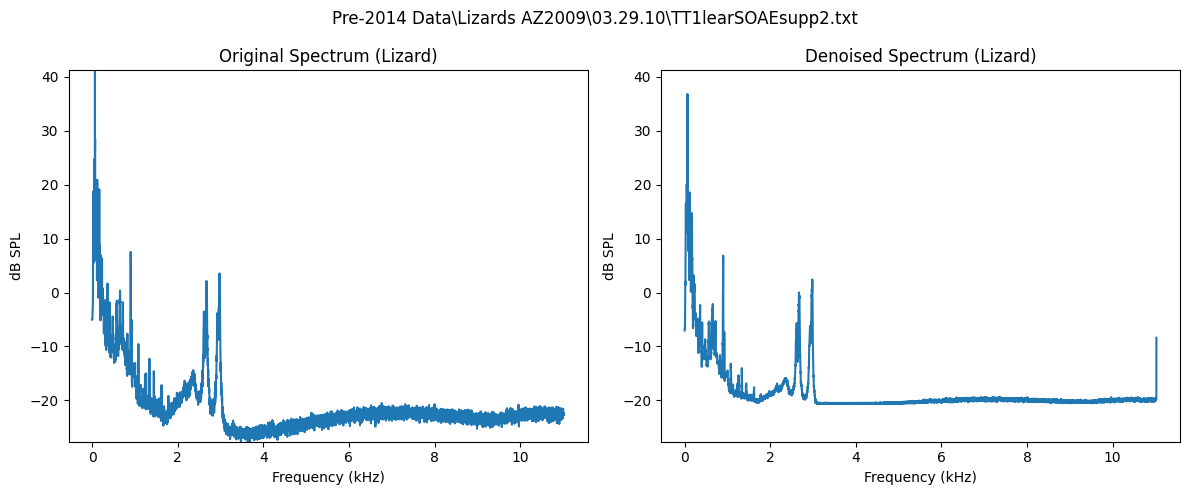

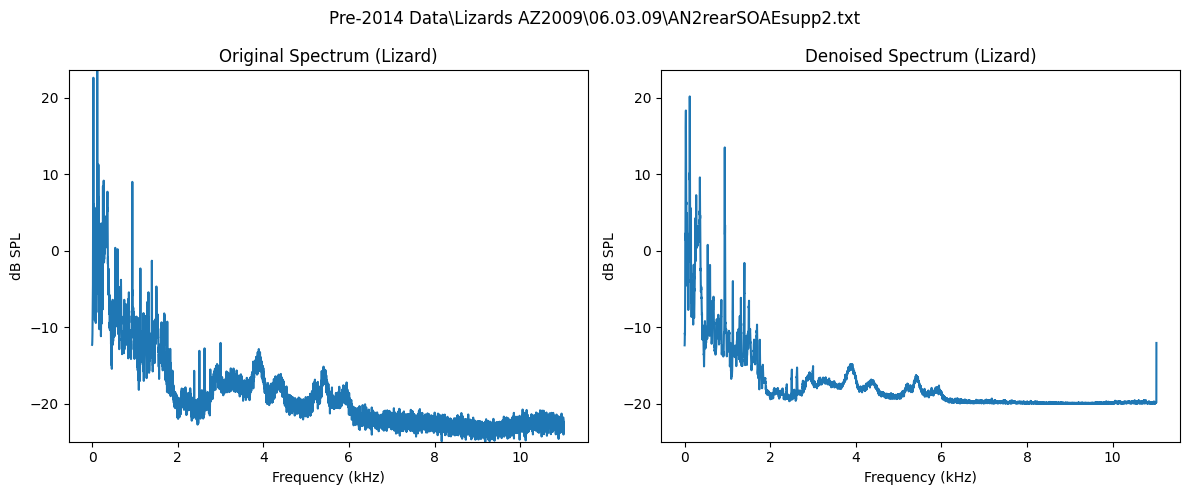

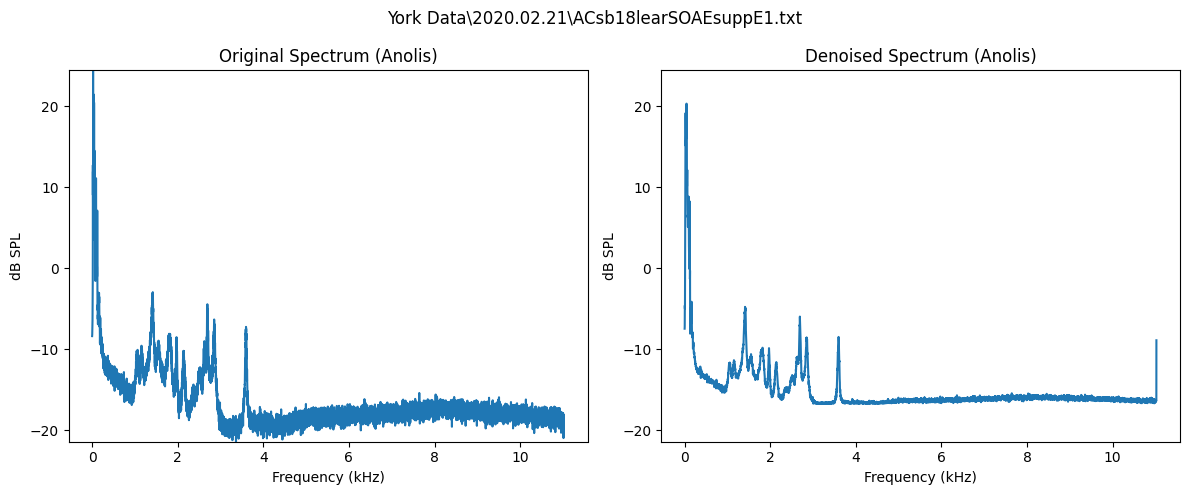

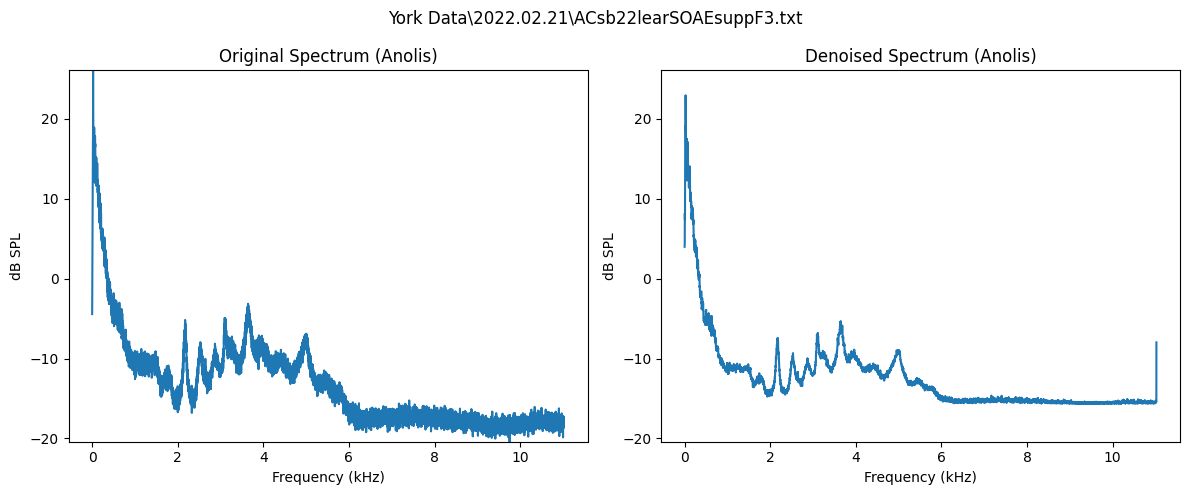

In [76]:
plot_ae_samples("cnn kernel=2 expx10 weighted mse kernel=50 l2=0.001", test_df, save=True)

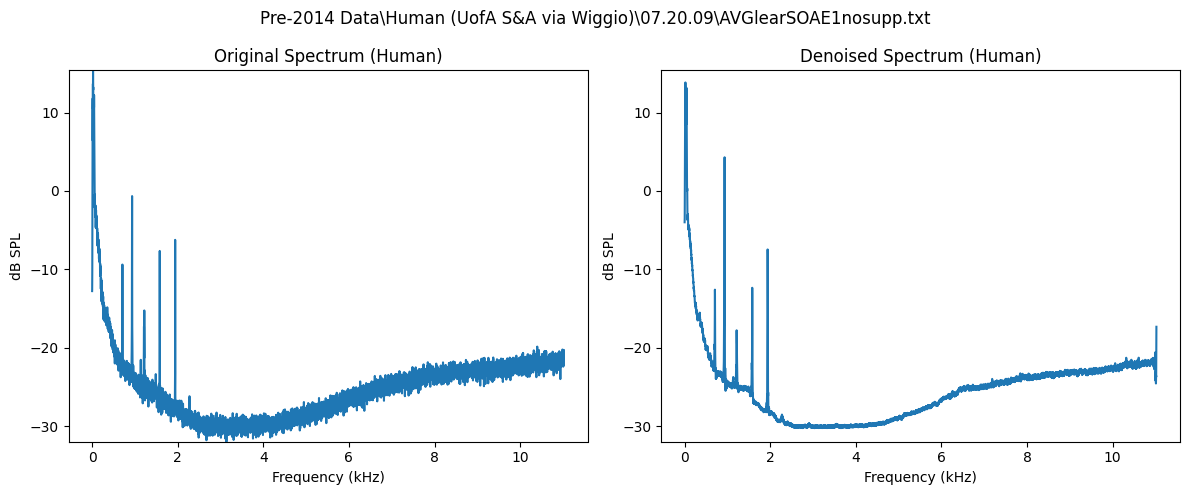

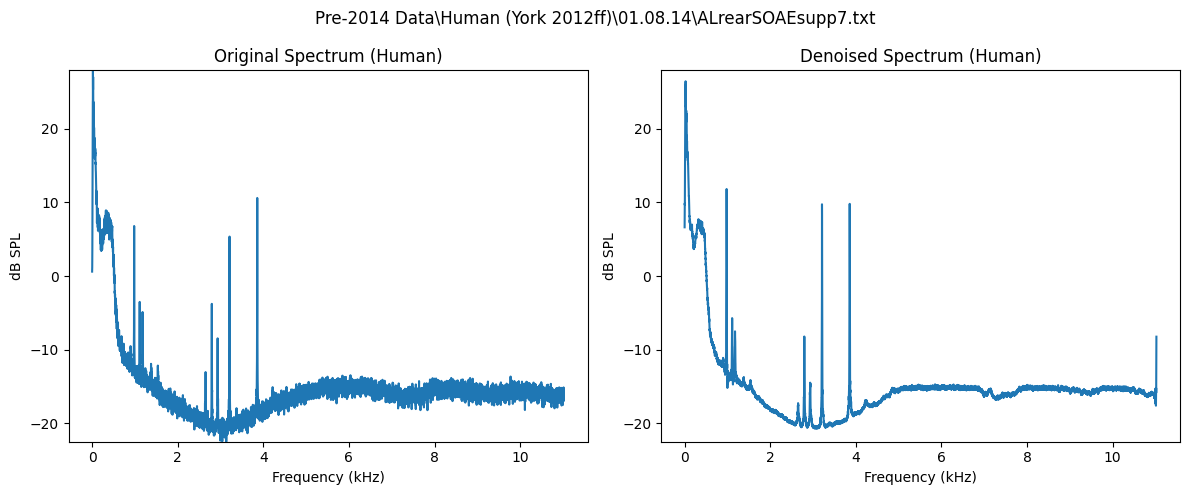

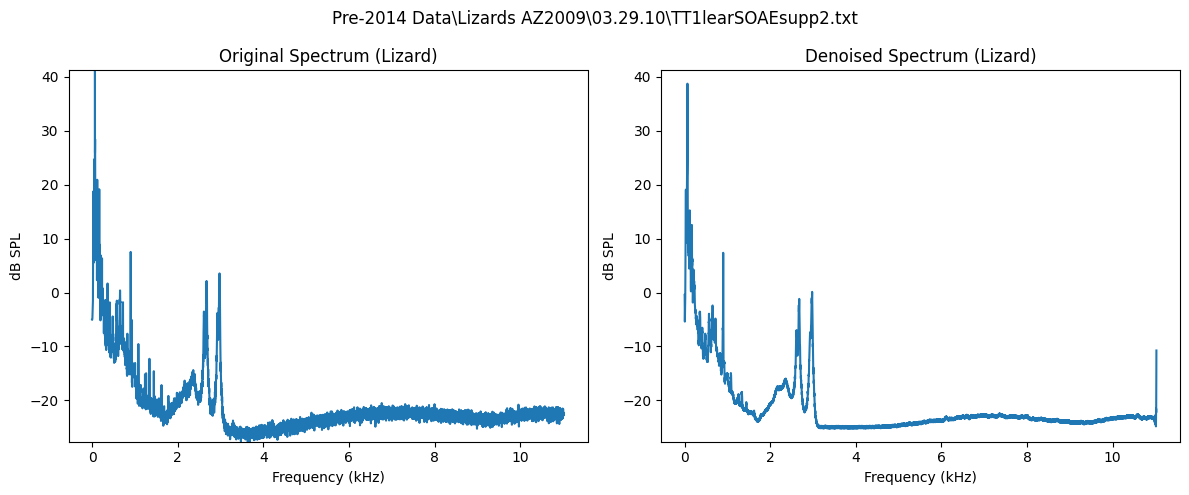

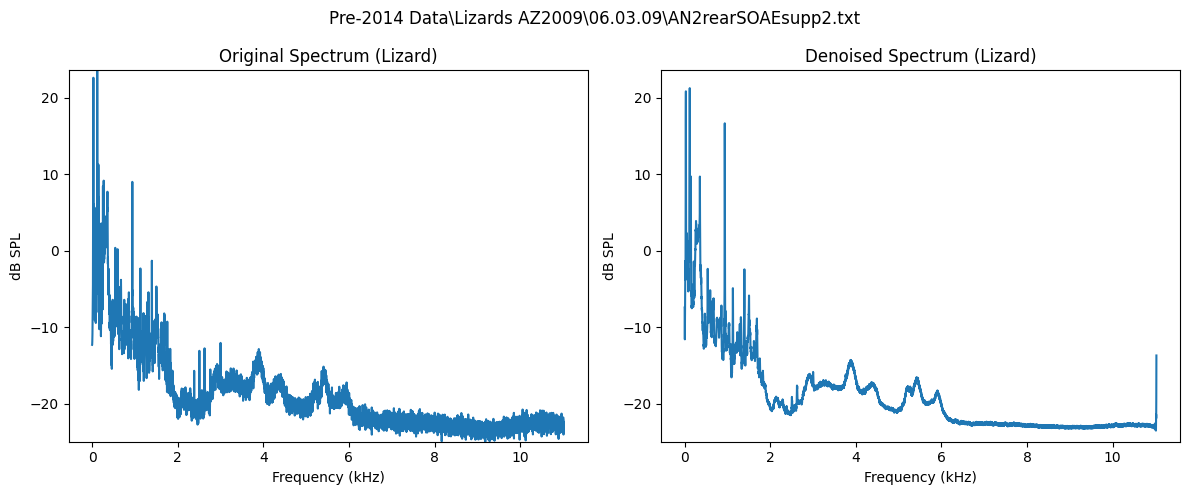

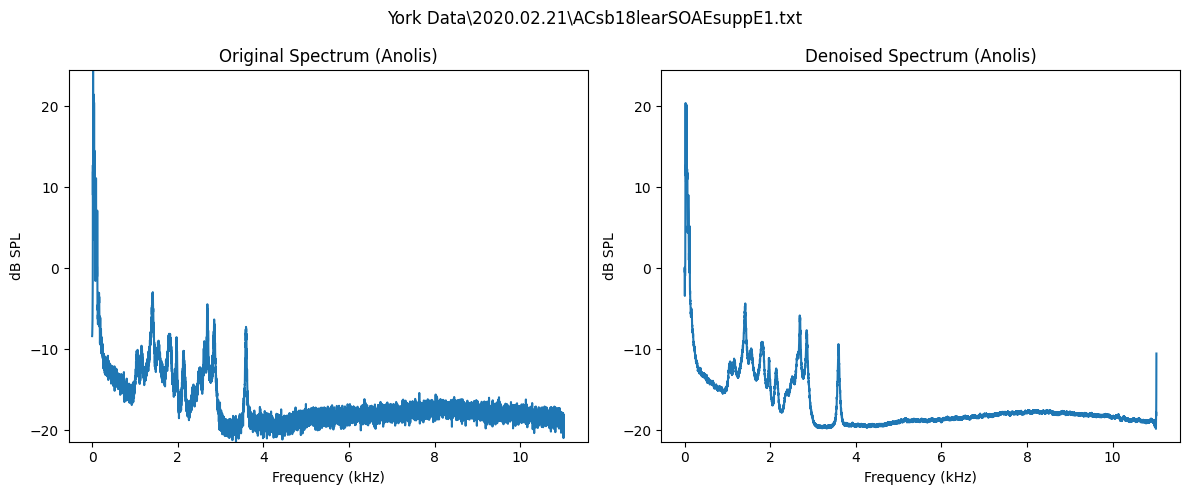

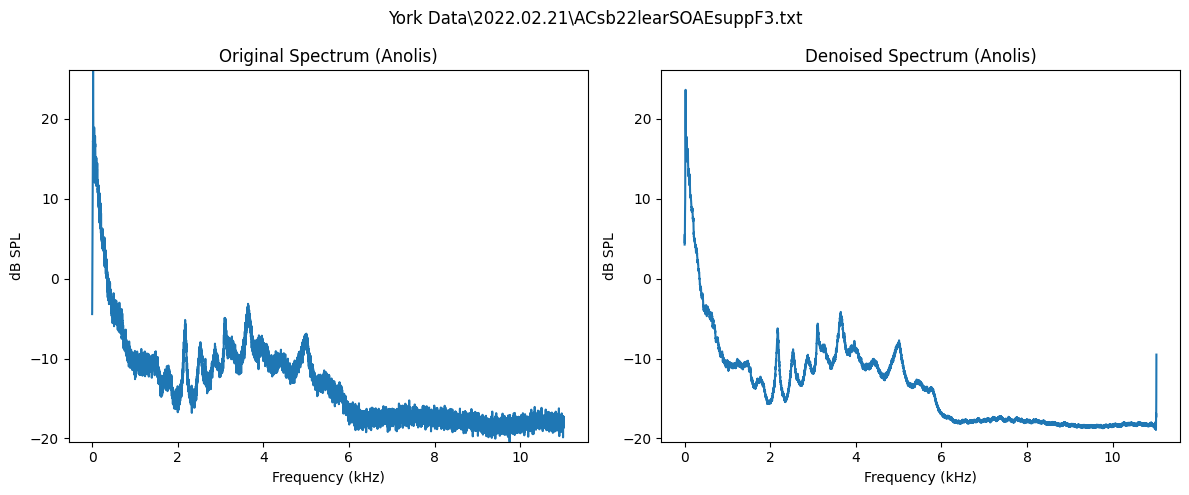

In [68]:
plot_ae_samples("cnn kernel=10 expx10 weighted mse kernel=50 l2=0.00001", test_df, save=True)

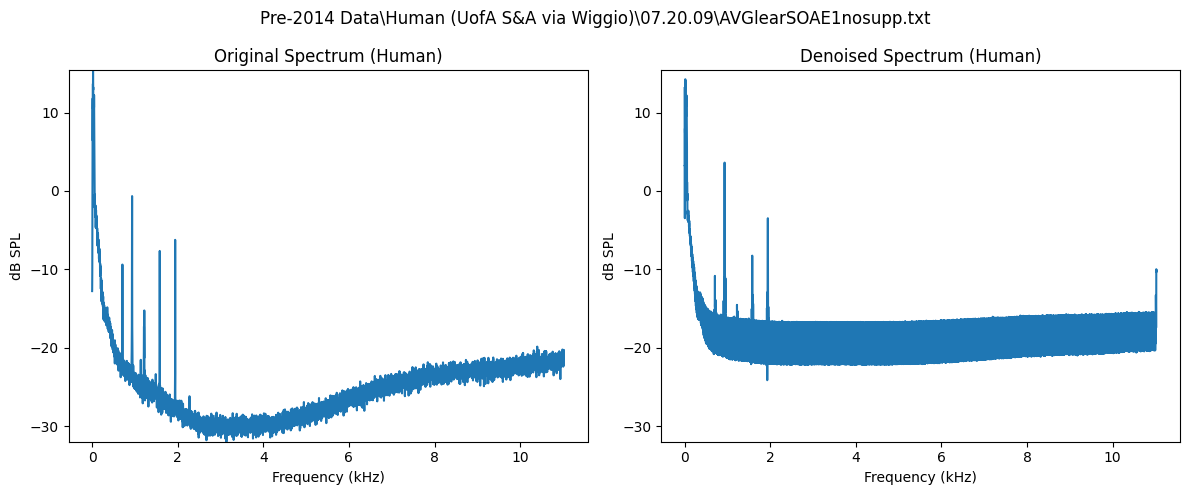

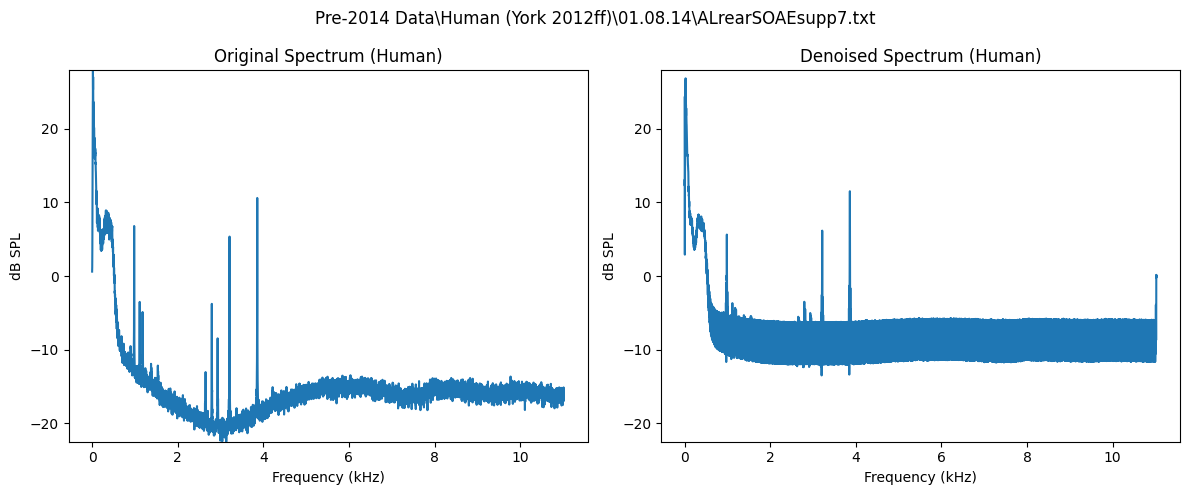

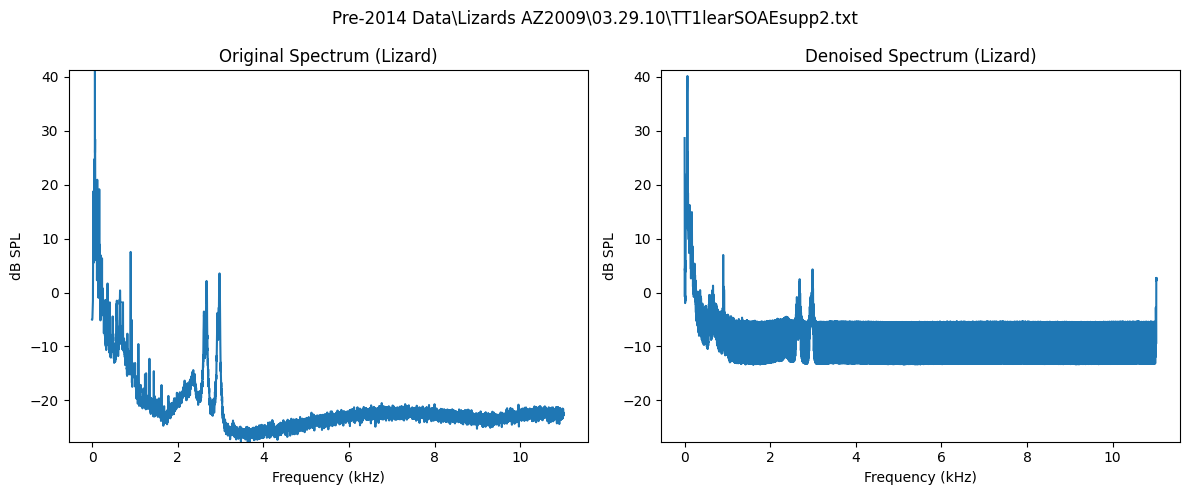

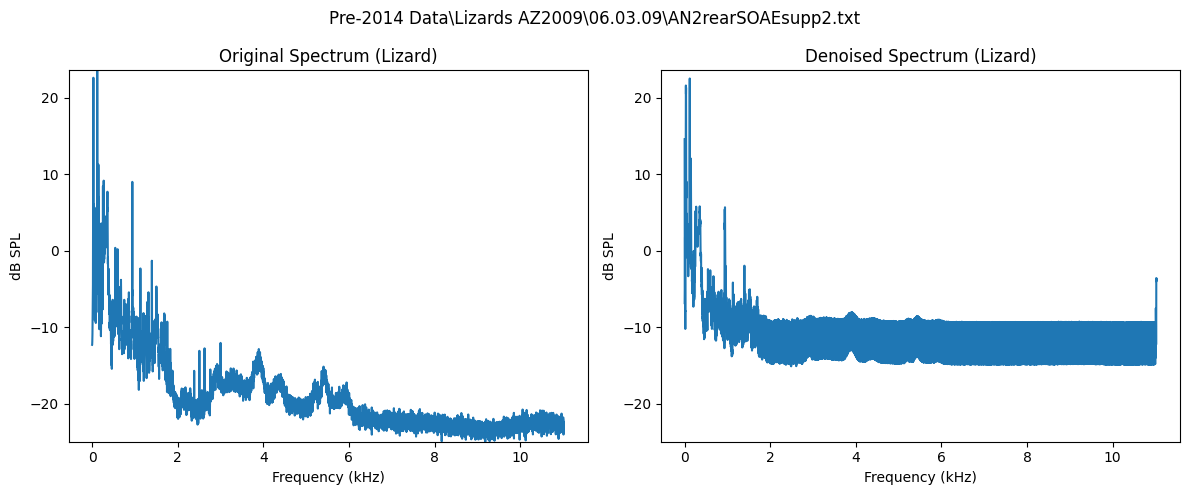

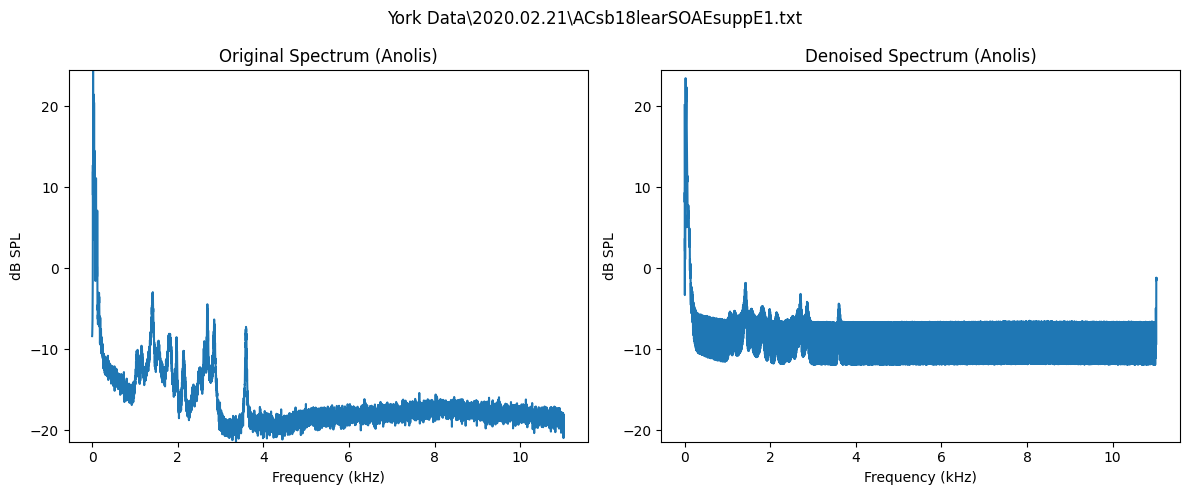

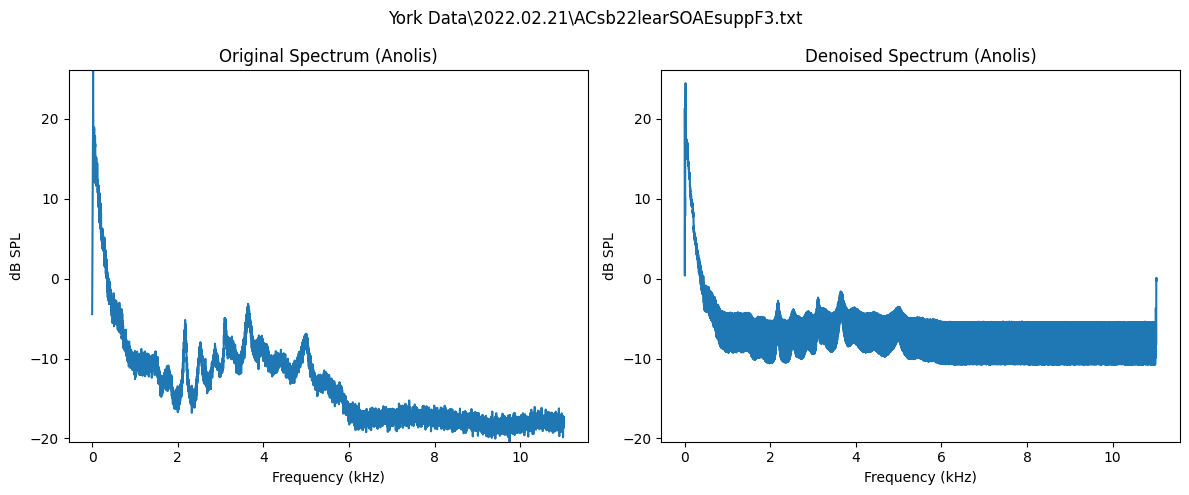

In [80]:
plot_ae_samples("expx20 weighted mse kernel=50 l2=0.00001", test_df, save=True)

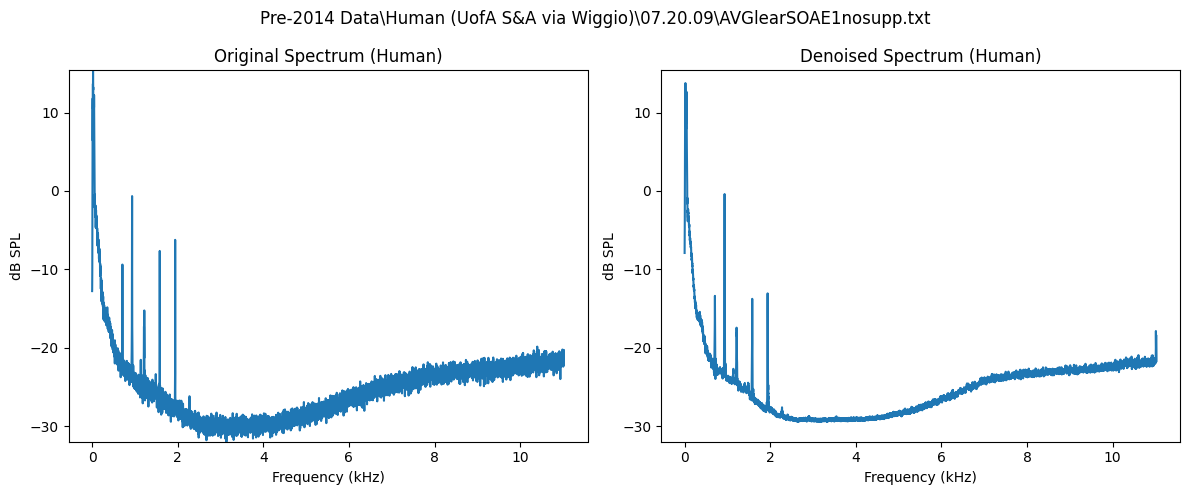

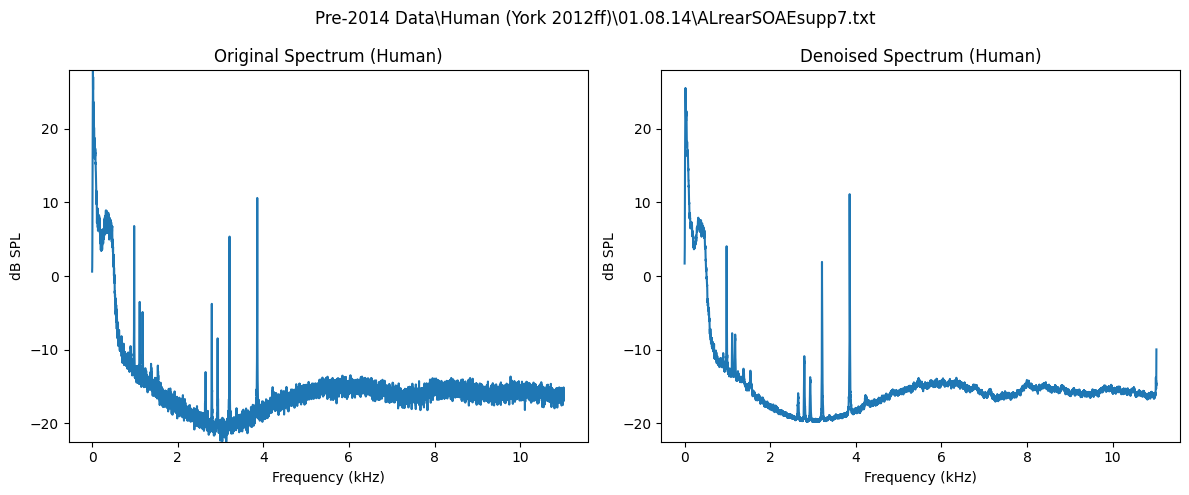

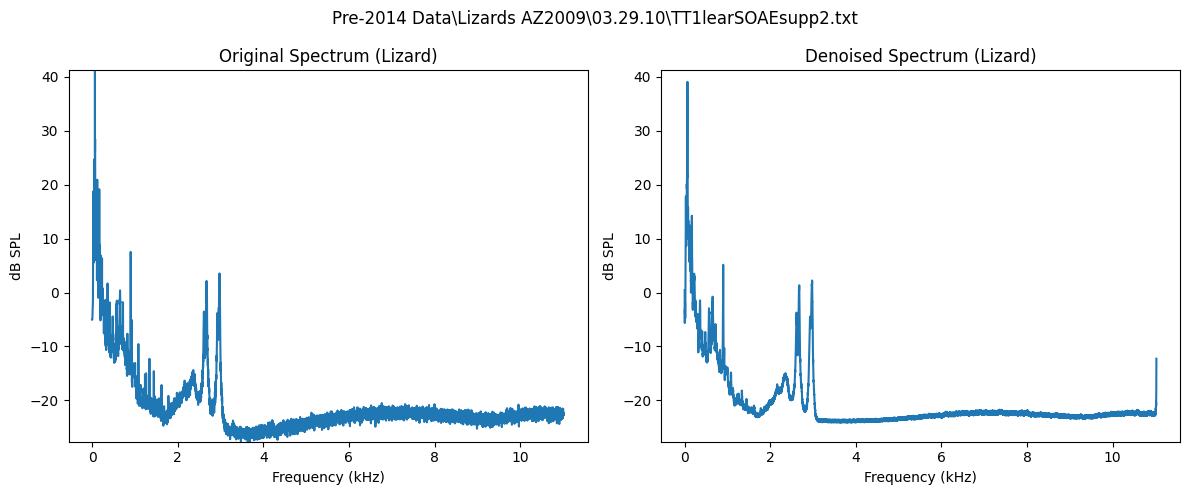

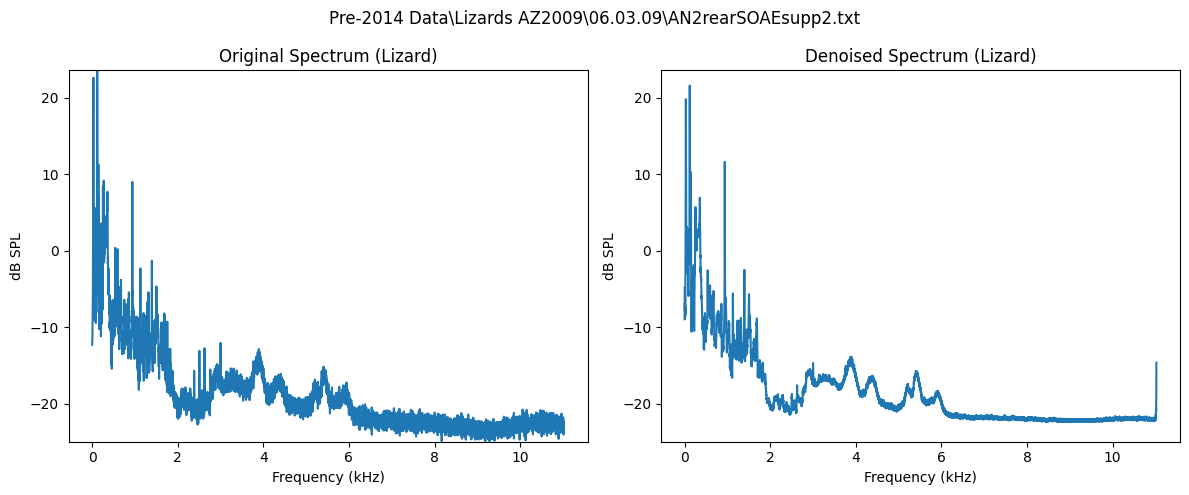

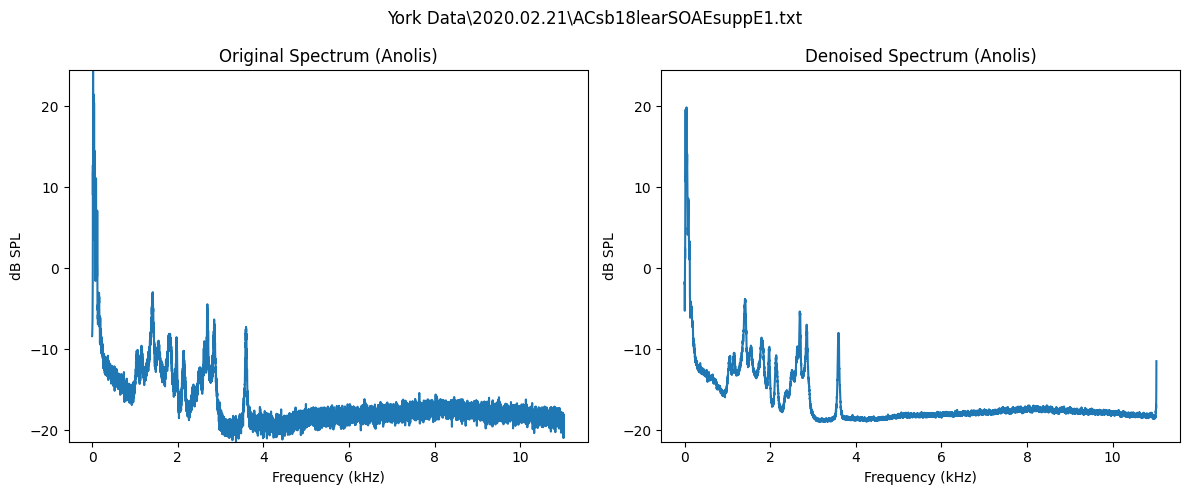

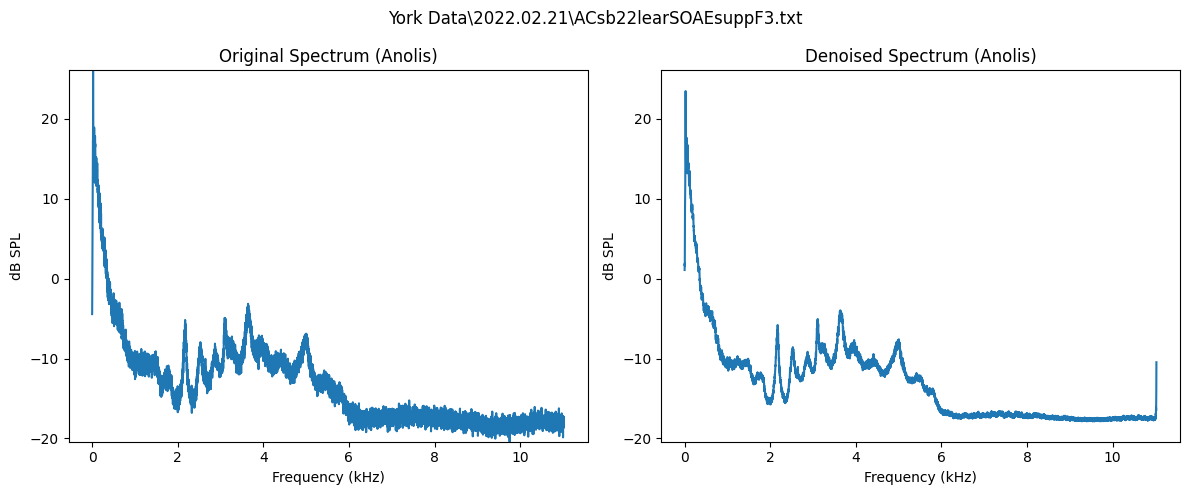

In [81]:
plot_ae_samples("expx10 weighted mse kernel=50 l2=0.00001", test_df, save=True)

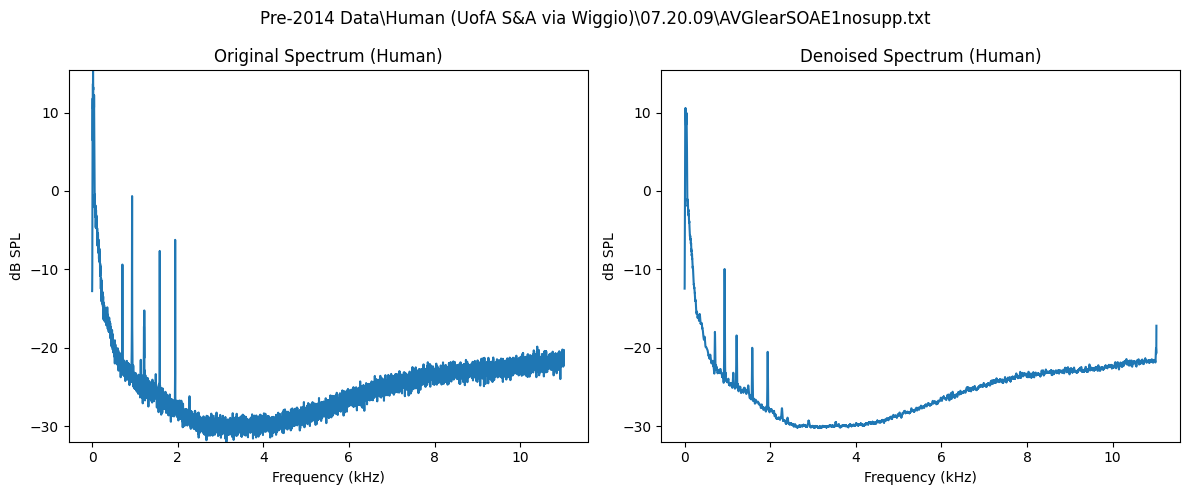

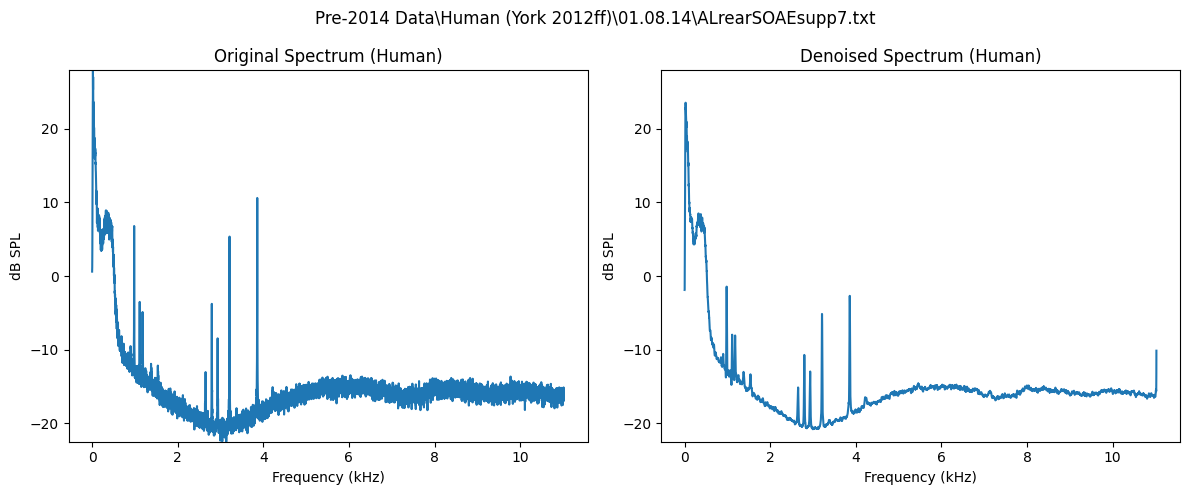

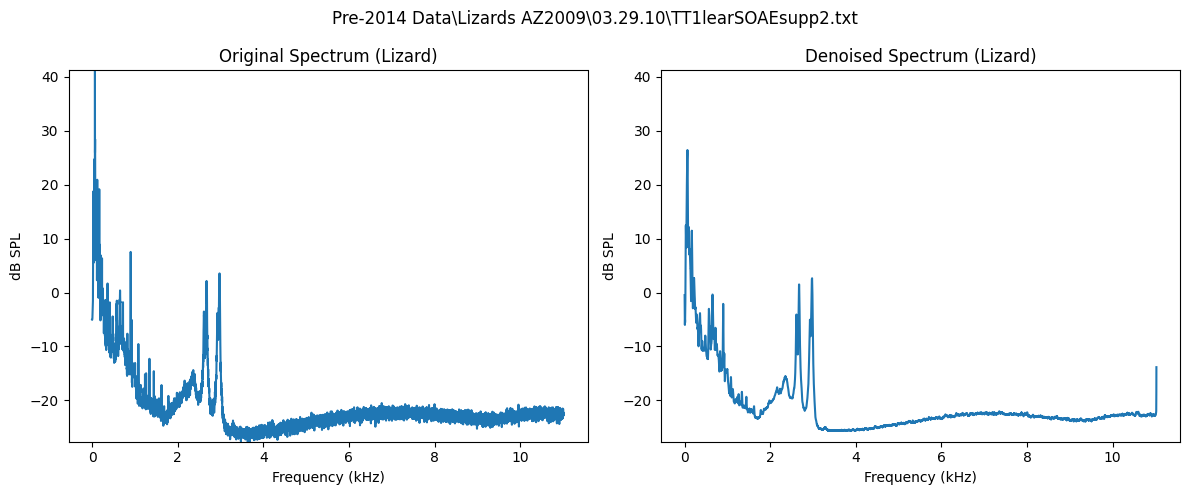

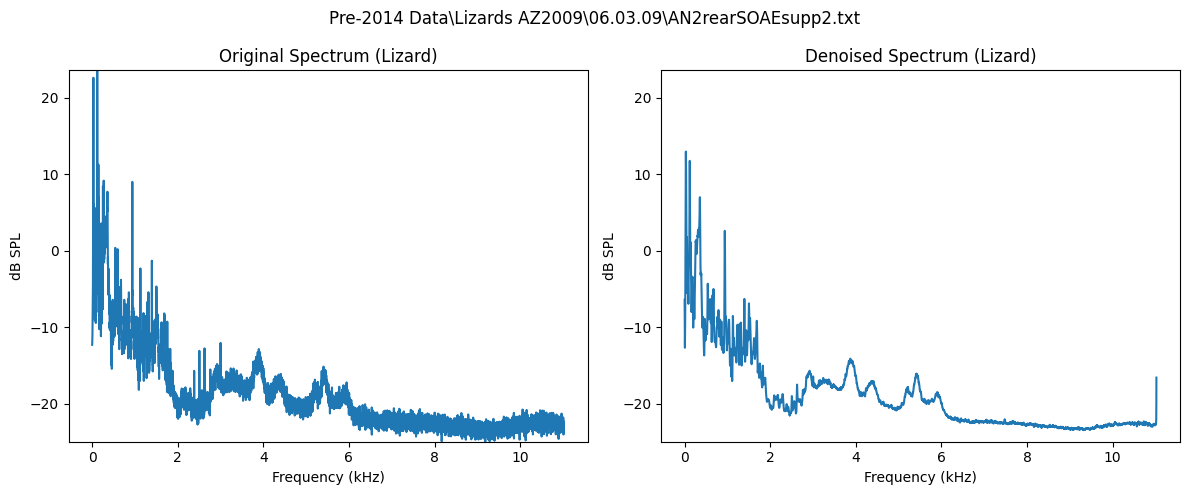

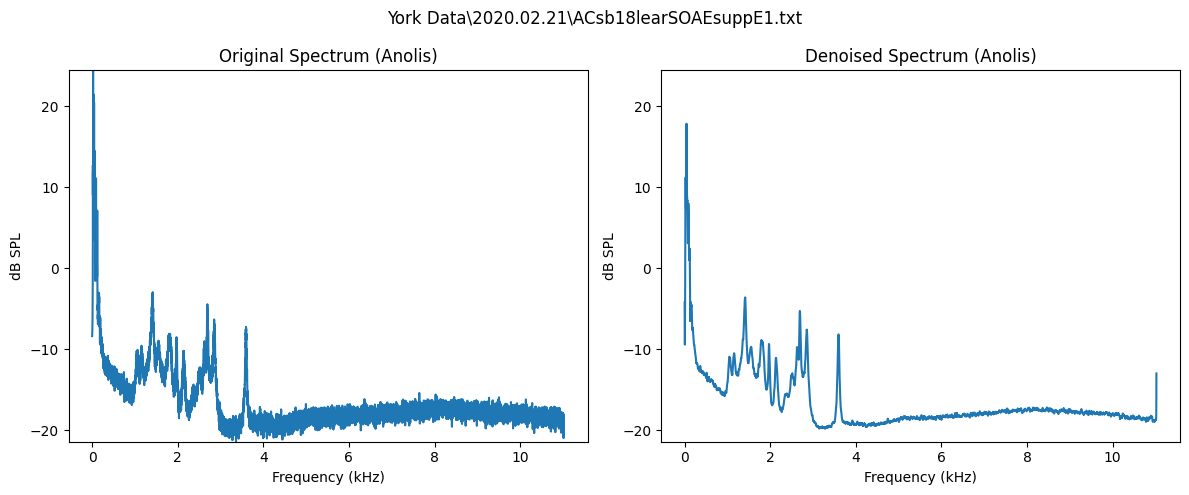

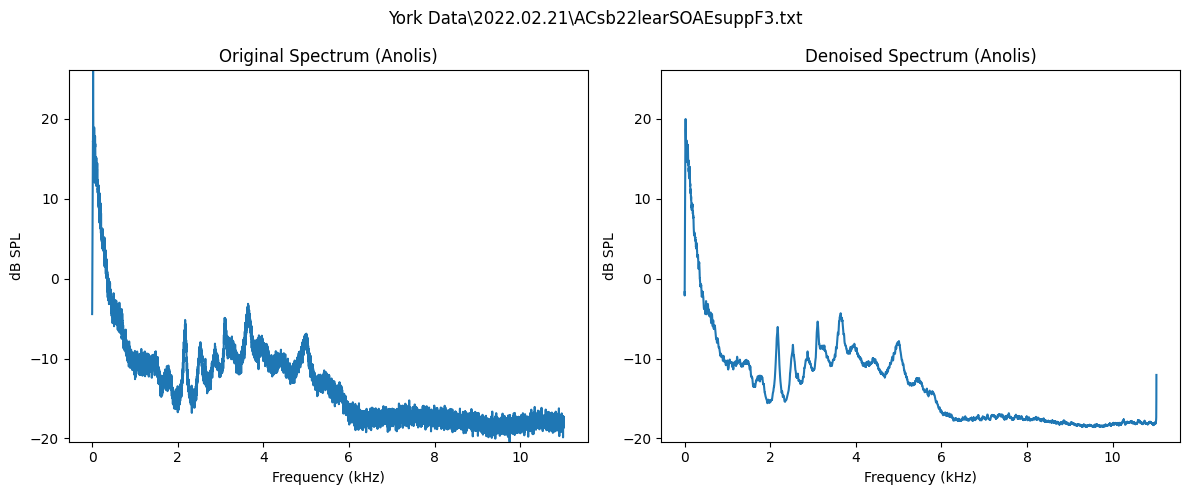

In [82]:
plot_ae_samples("weighted mse kernel=50 l2=0.00001", test_df, save=True)

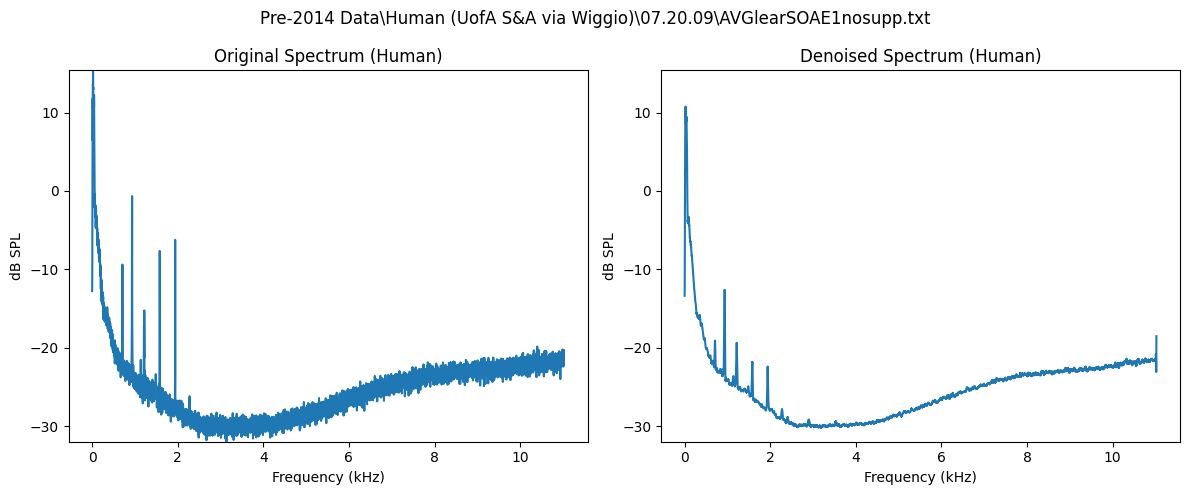

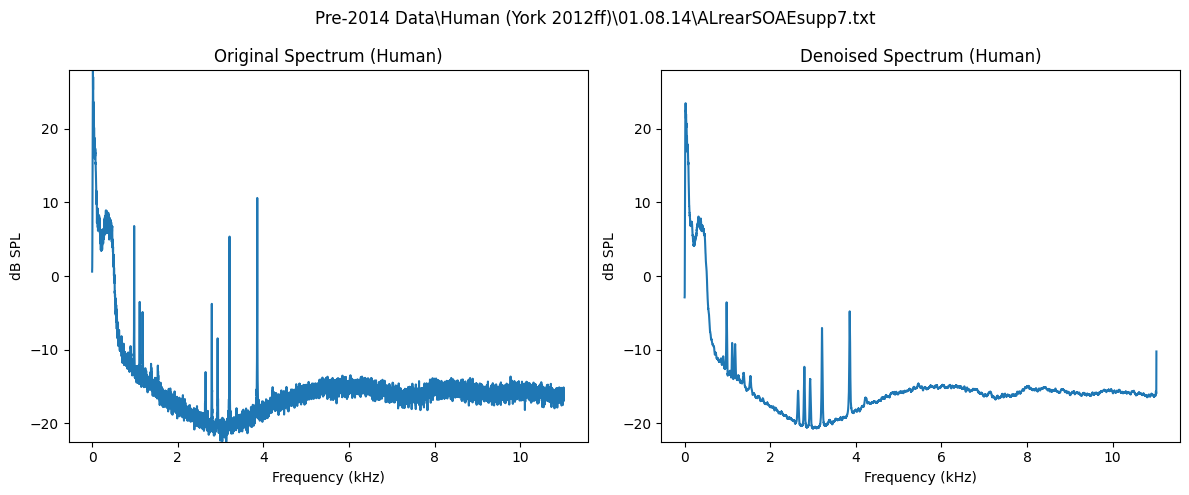

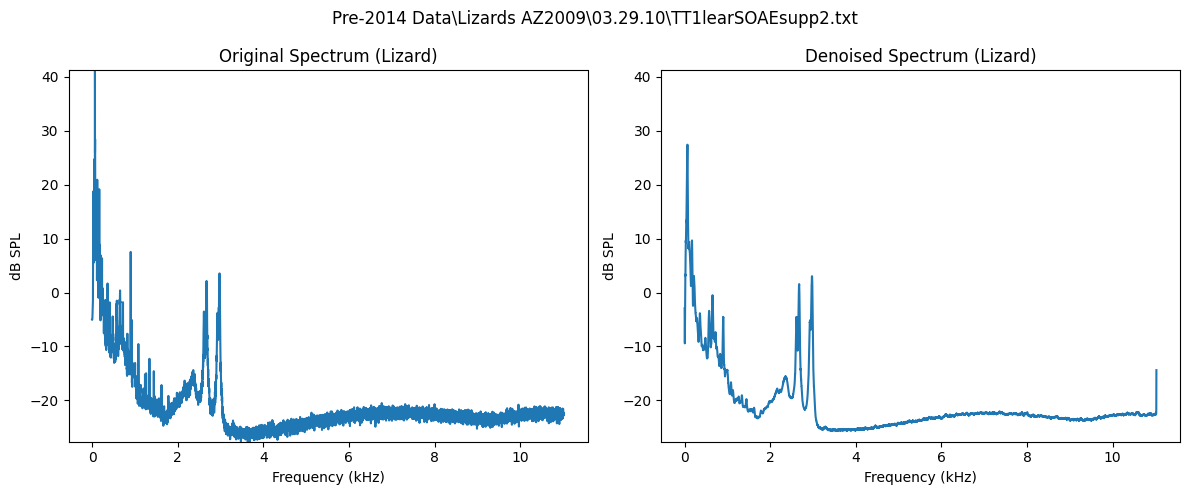

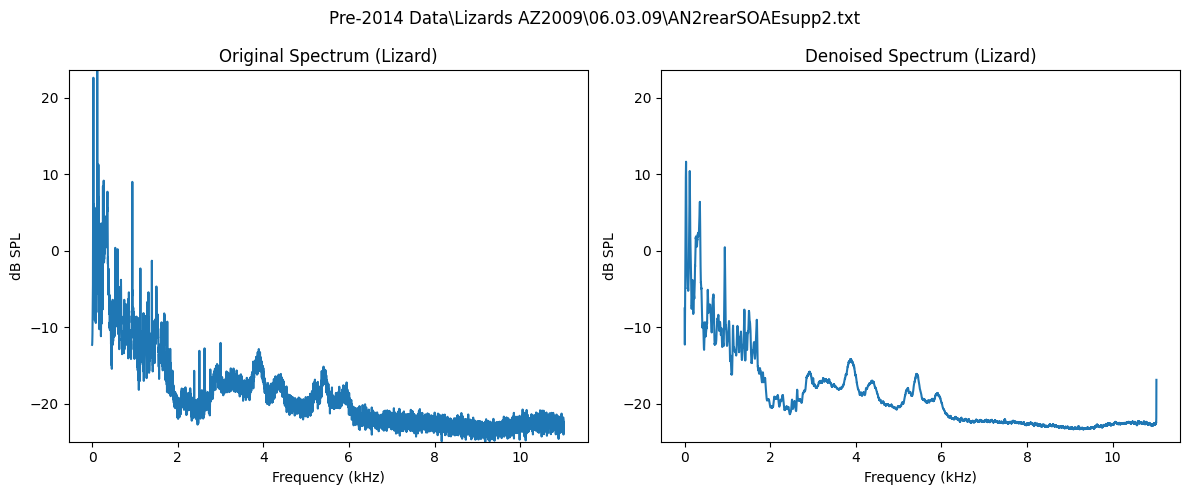

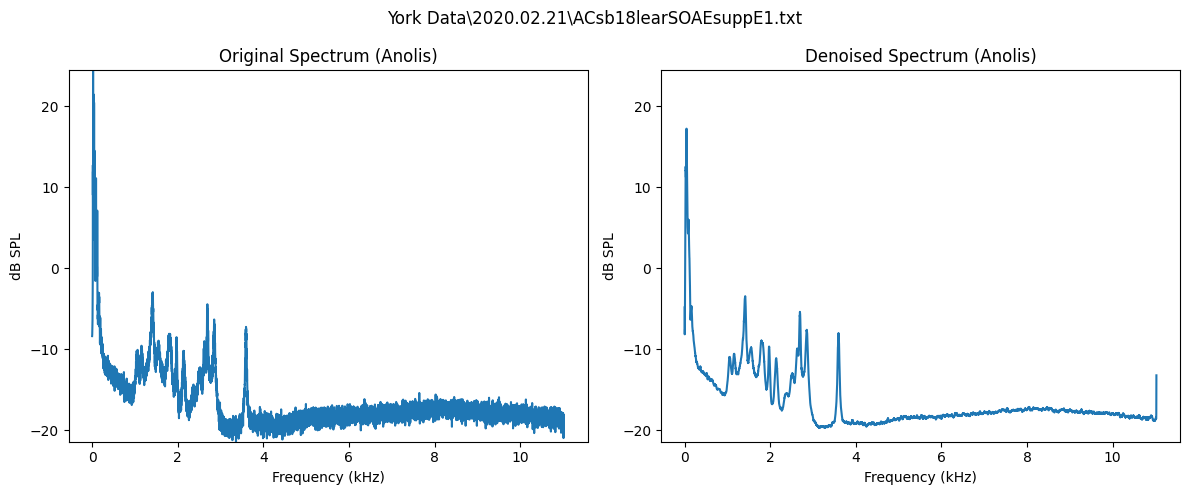

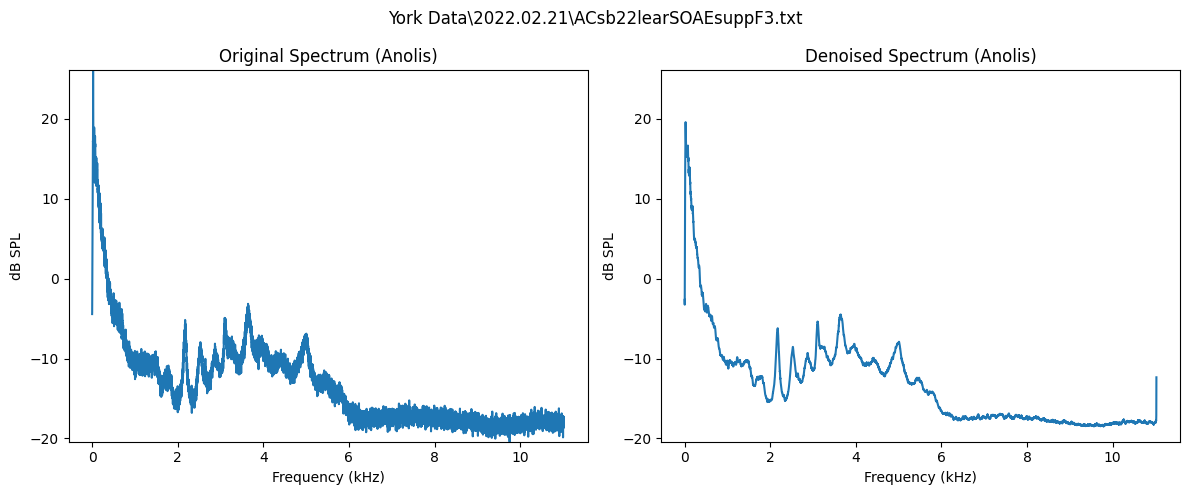

In [83]:
plot_ae_samples("weighted mse kernel=100 l2=0.00001", test_df, save=True)

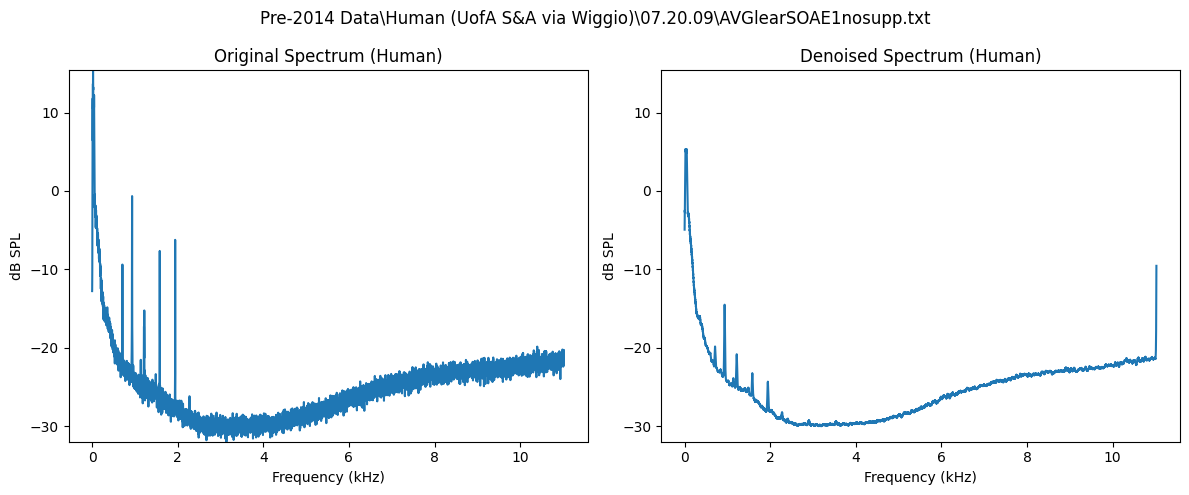

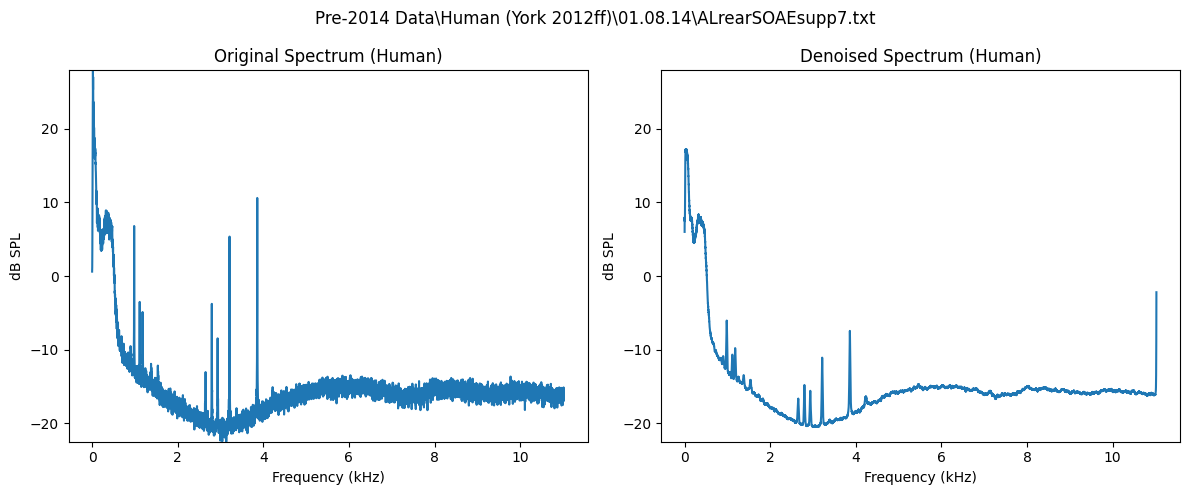

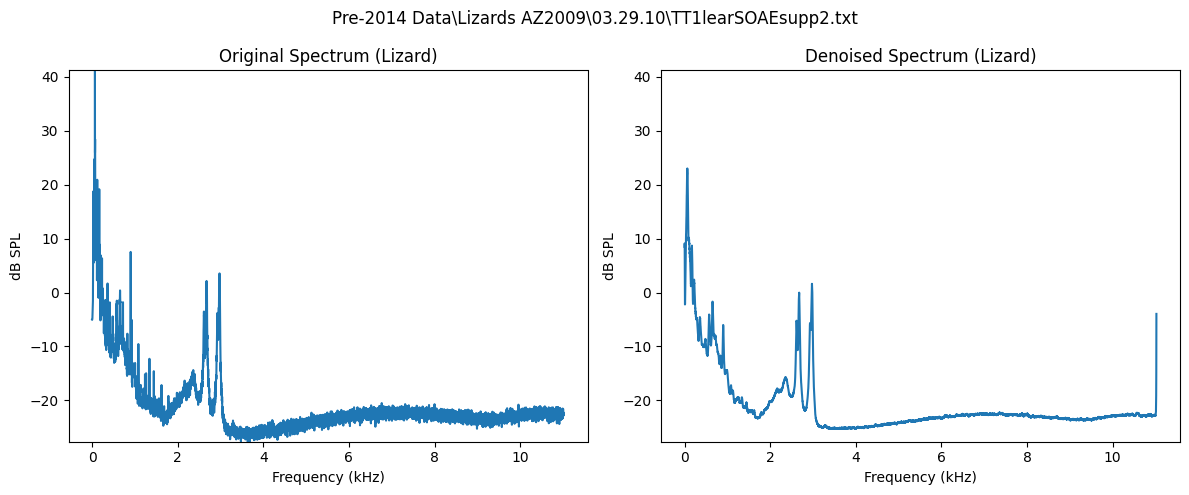

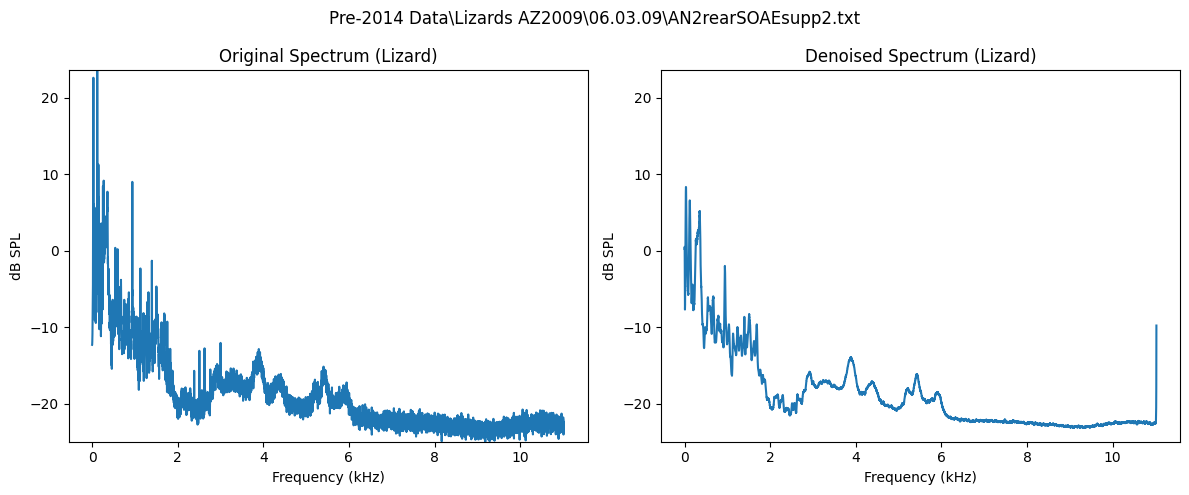

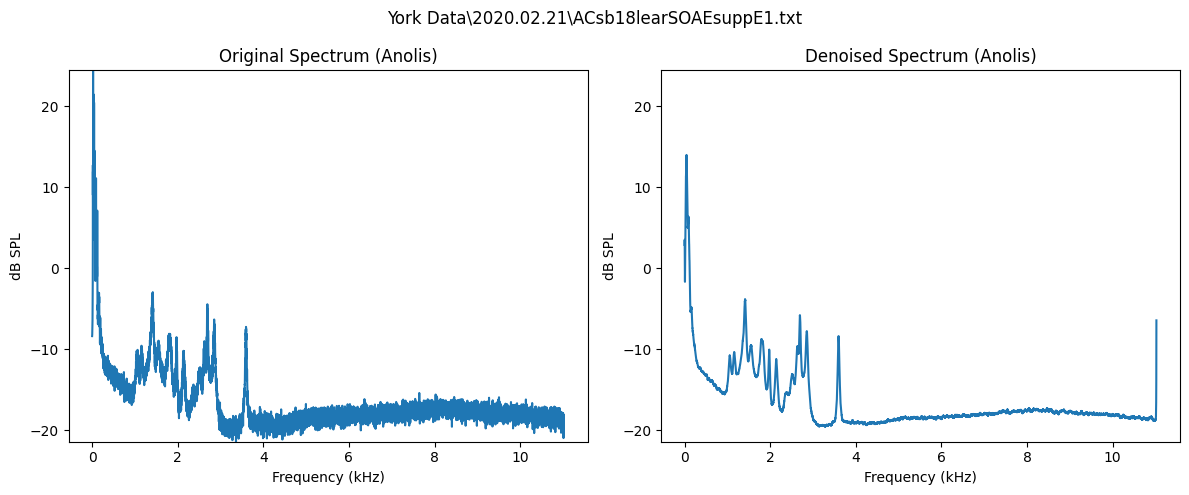

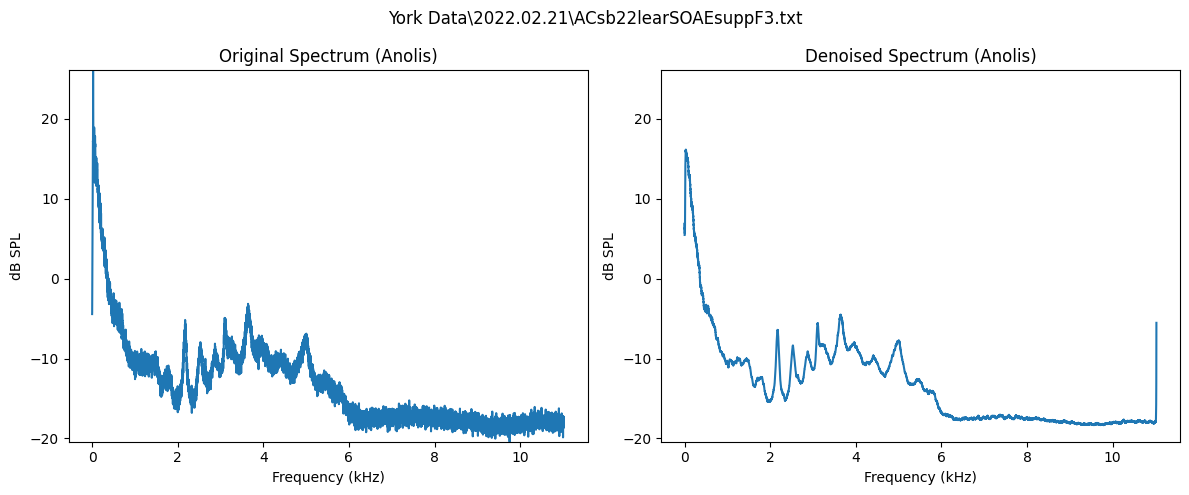

In [84]:
plot_ae_samples("weighted mse kernel=50 l2=0.0001", test_df, save=True)

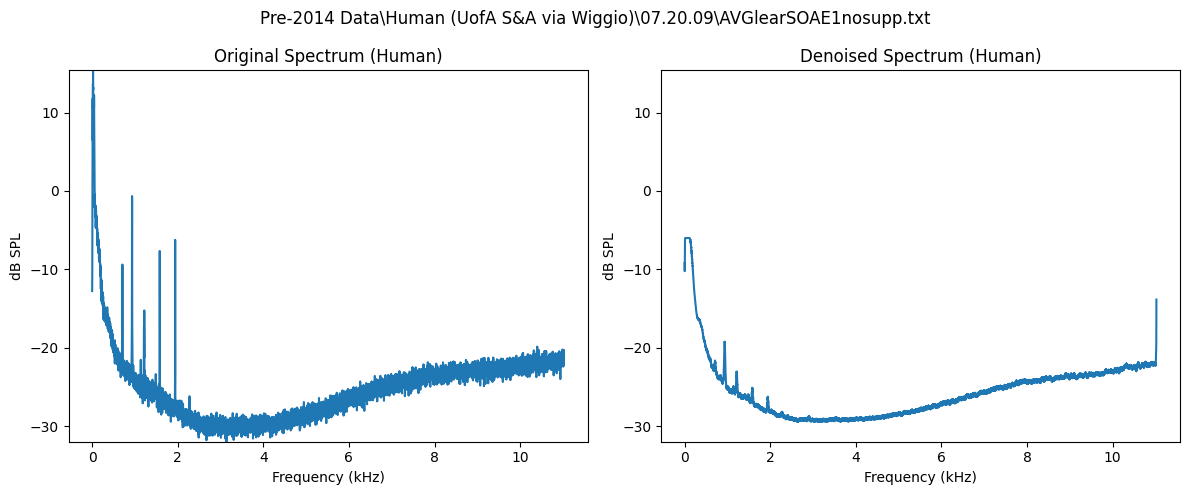

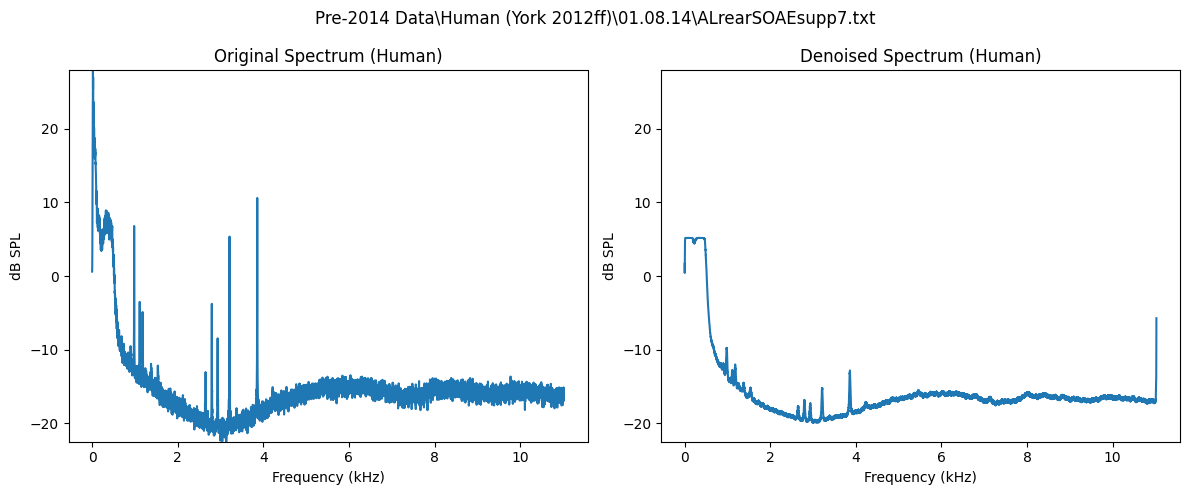

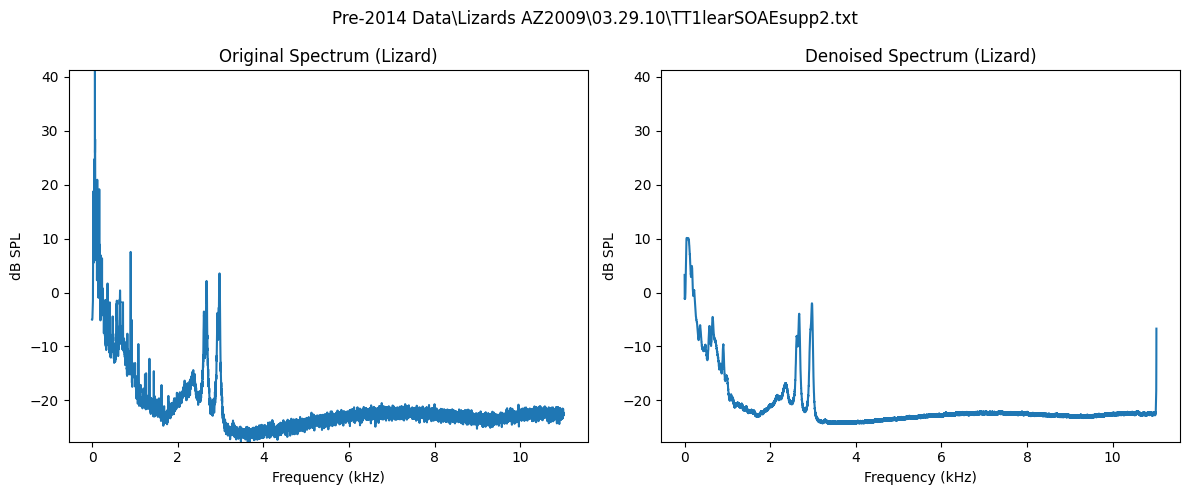

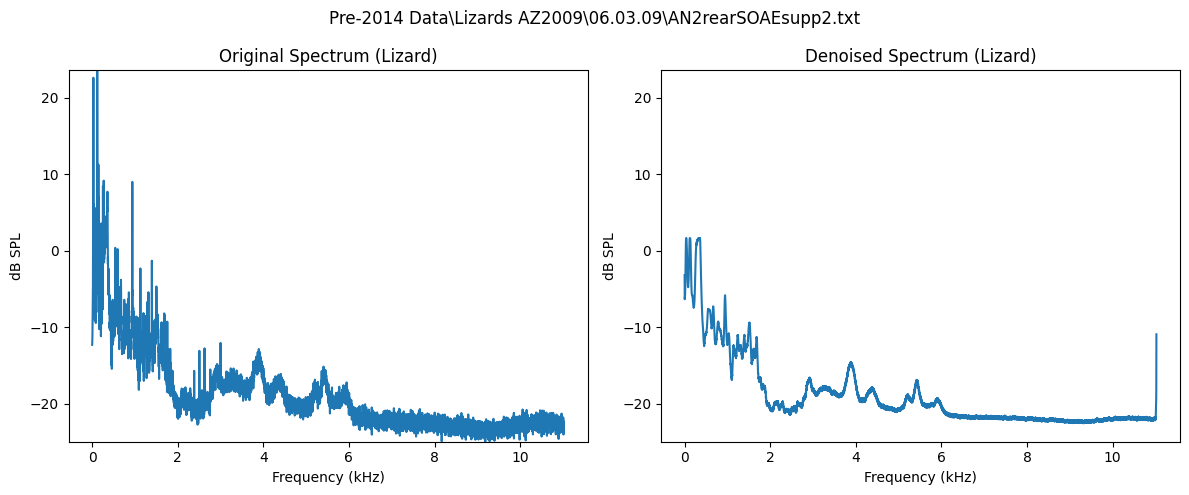

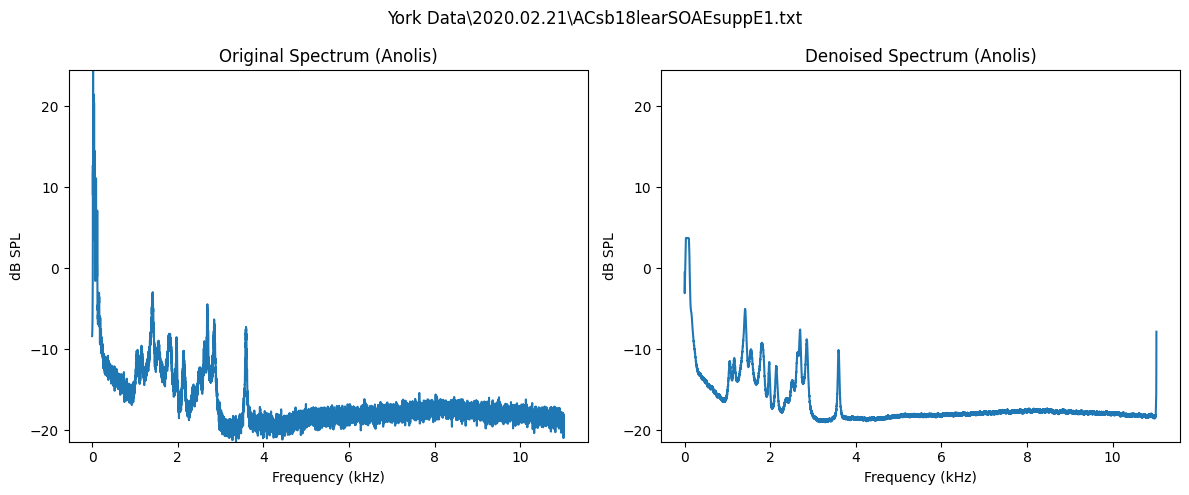

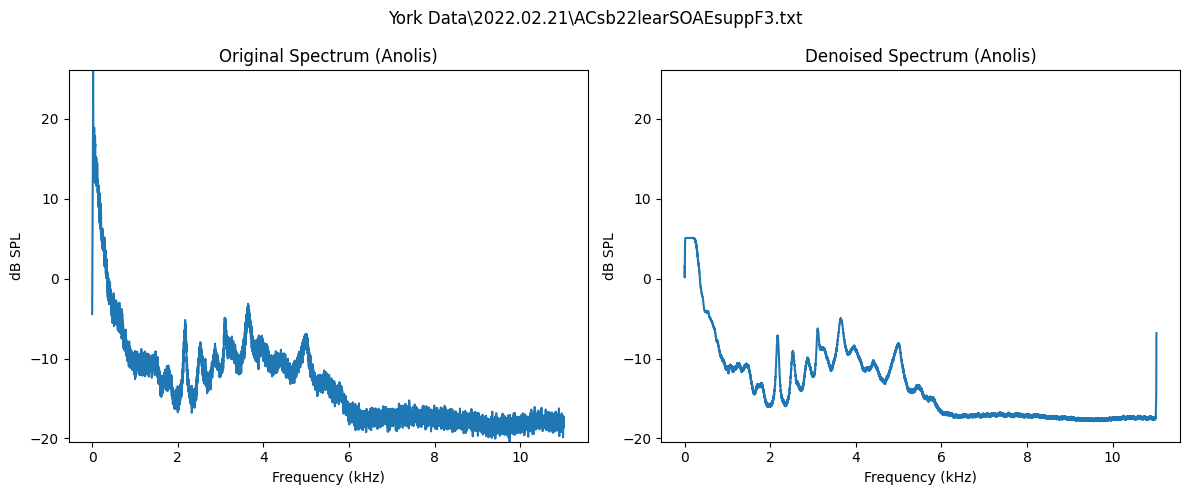

In [85]:
plot_ae_samples("weighted mse kernel=50 l2=0.001", test_df, save=True)

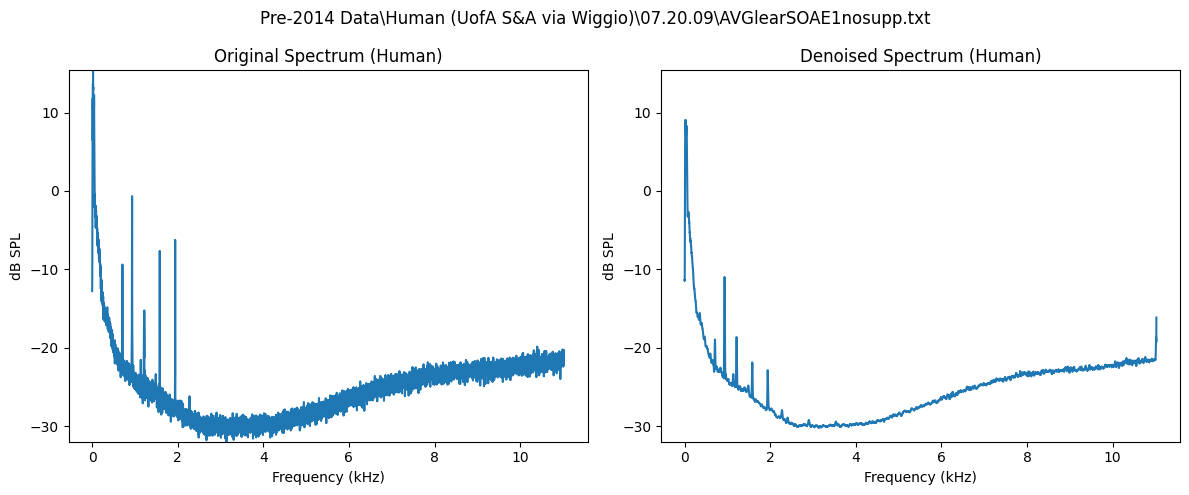

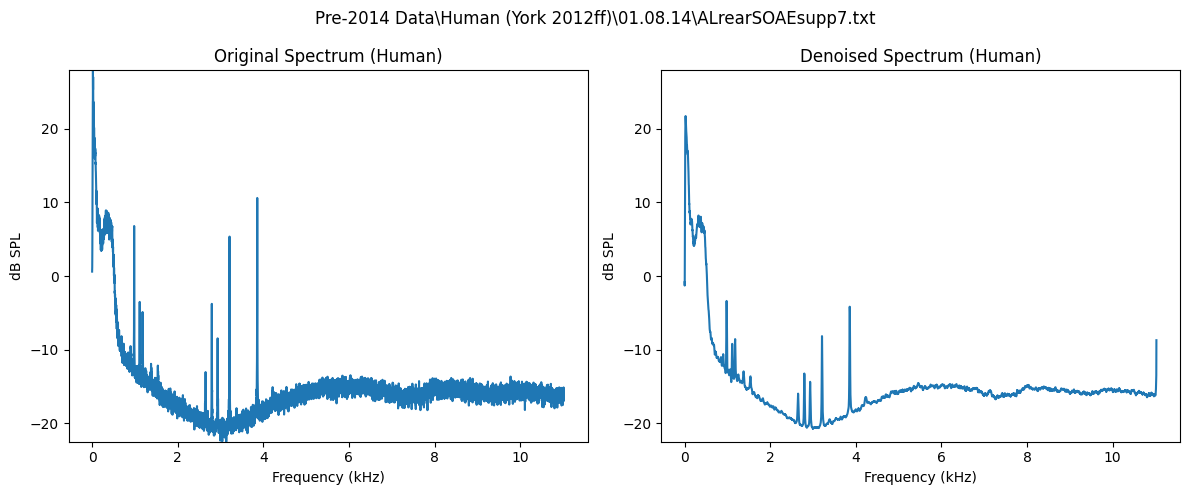

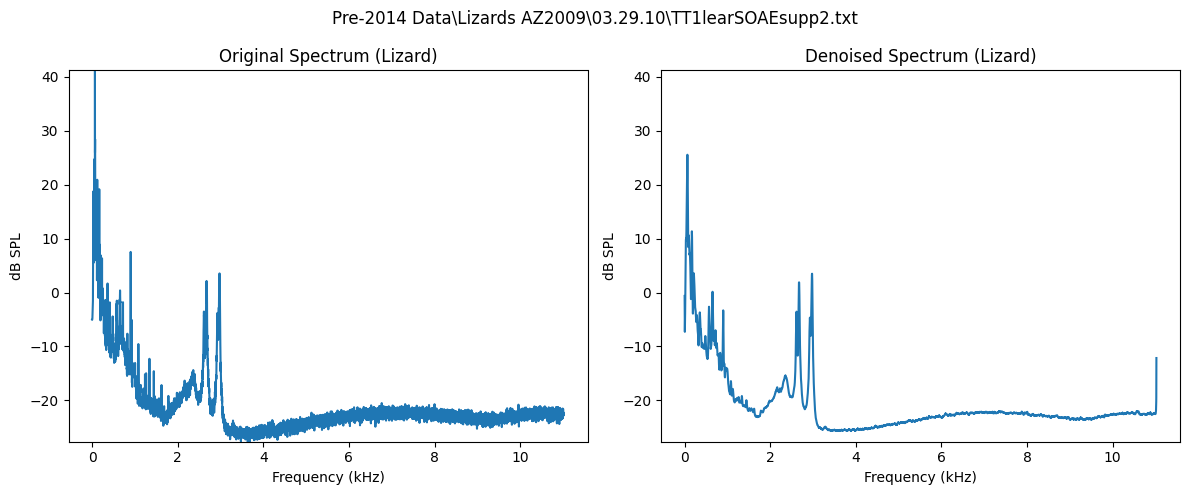

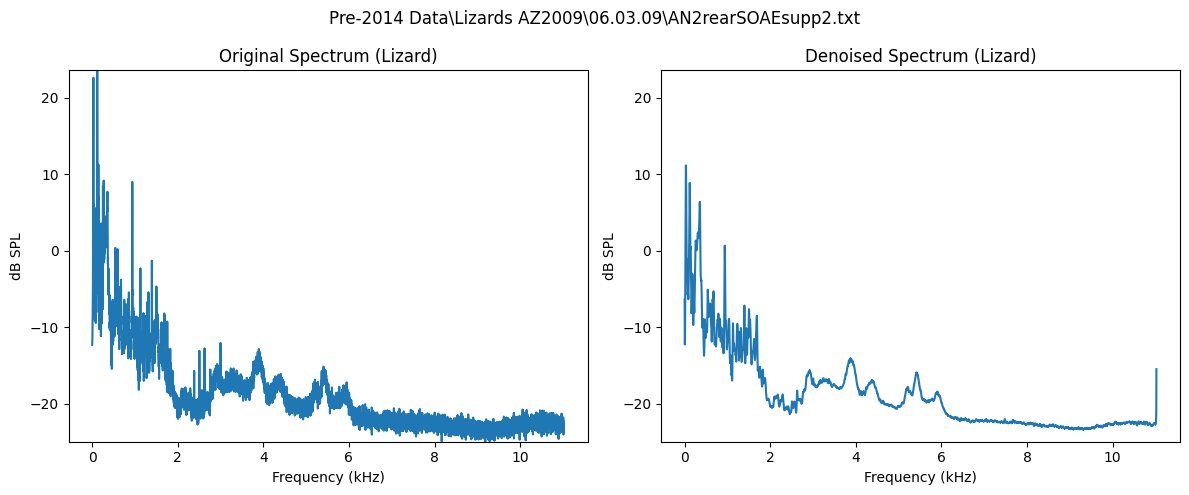

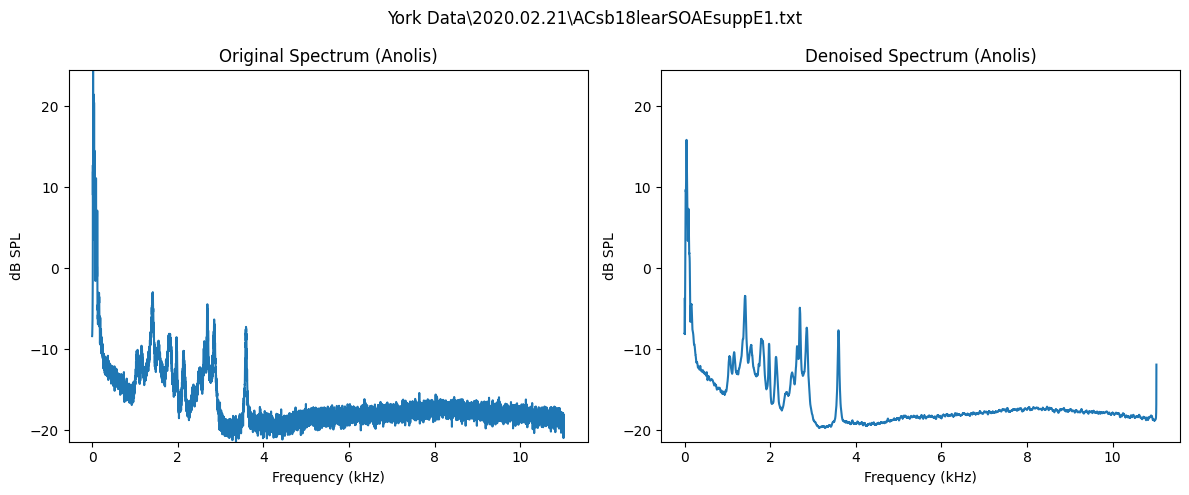

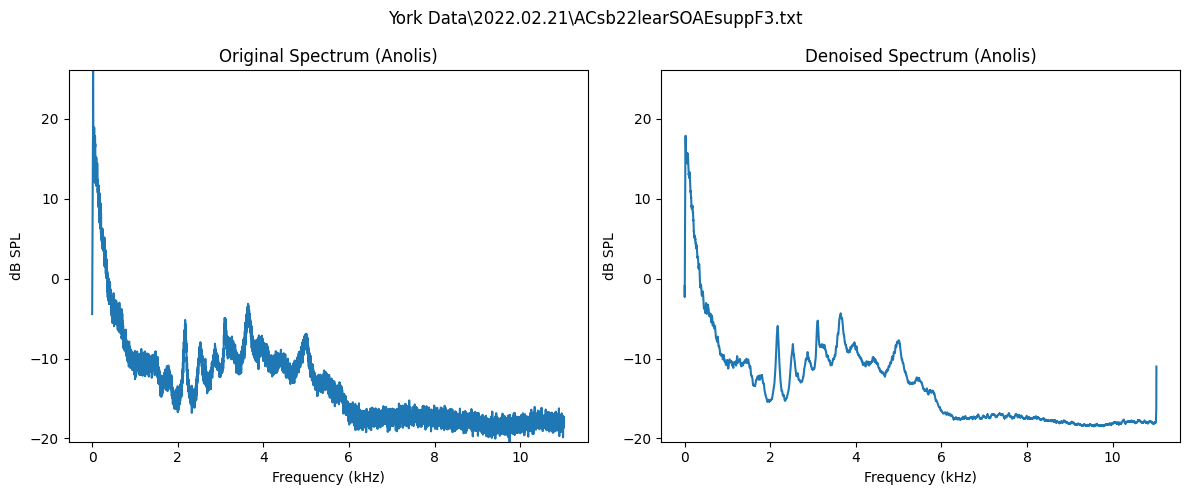

In [86]:
plot_ae_samples("original l2=0.00001", test_df, save=True)

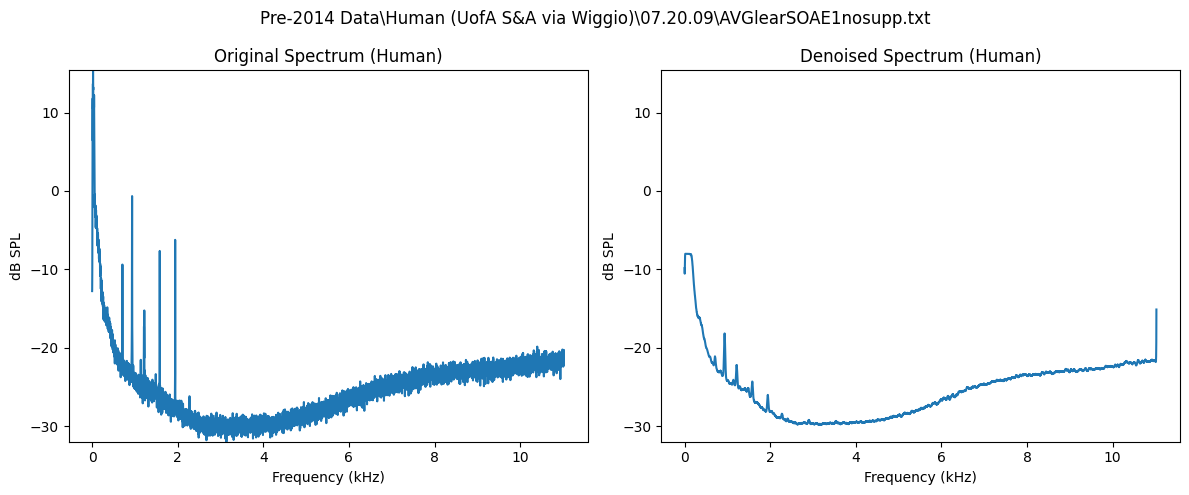

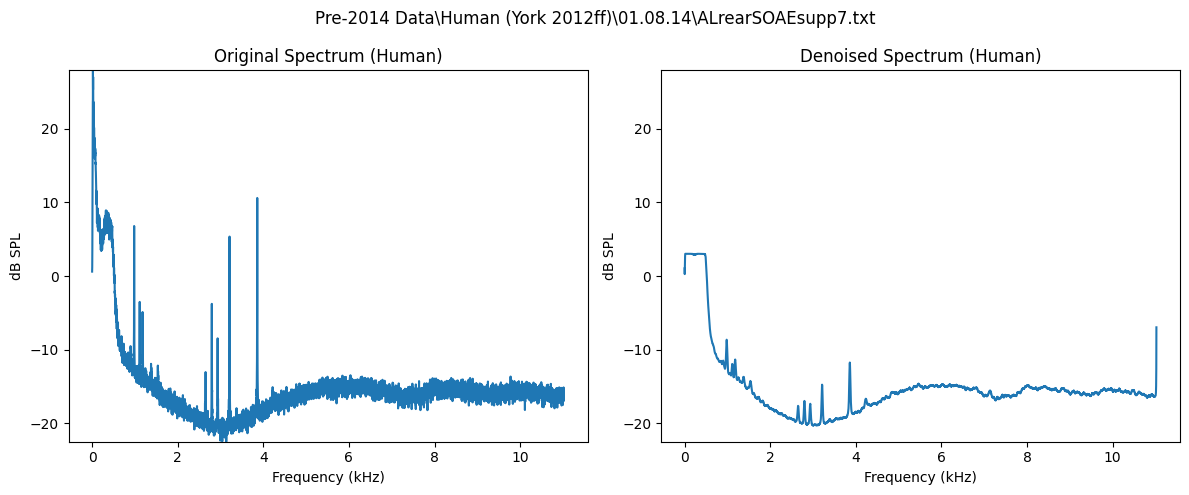

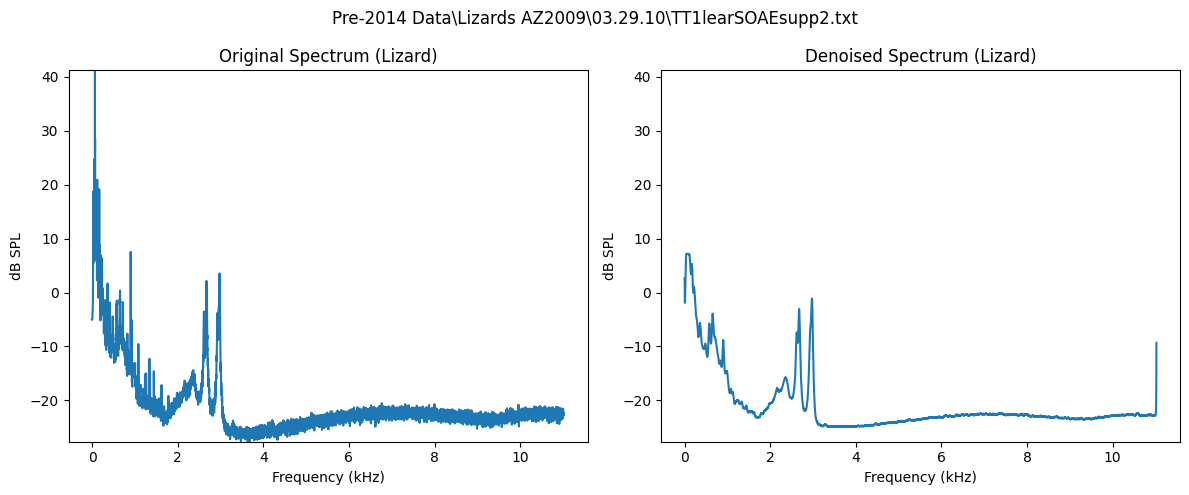

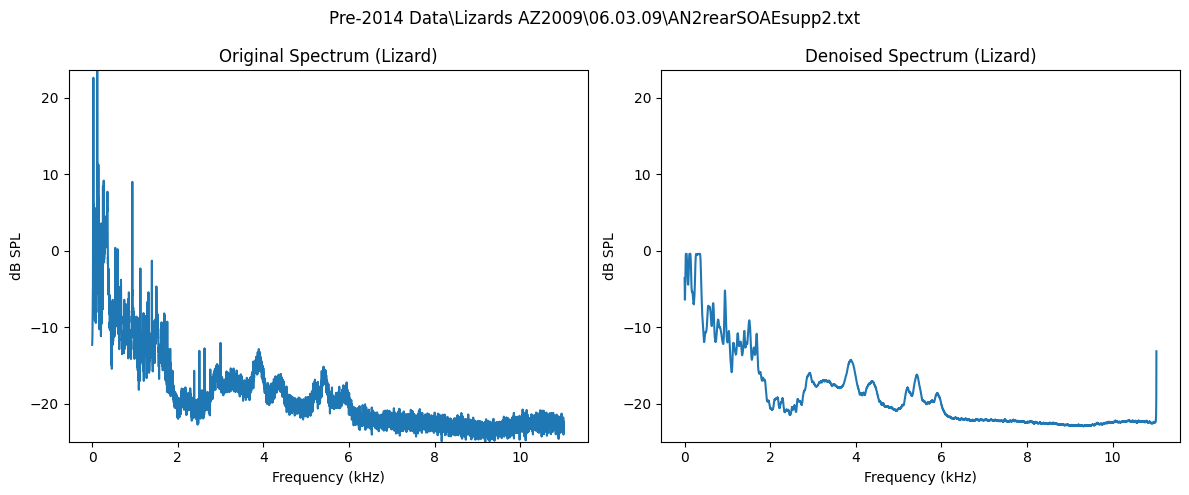

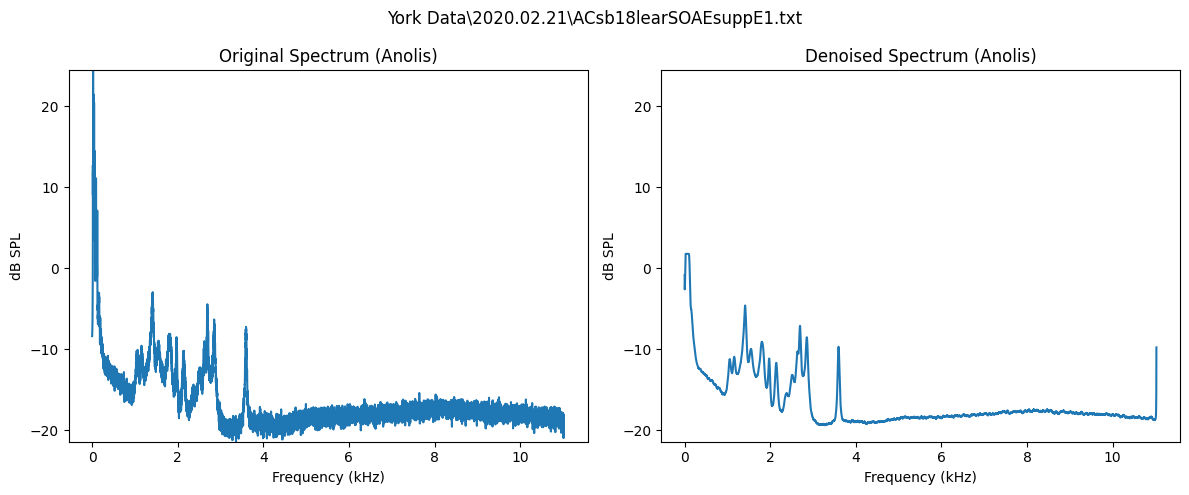

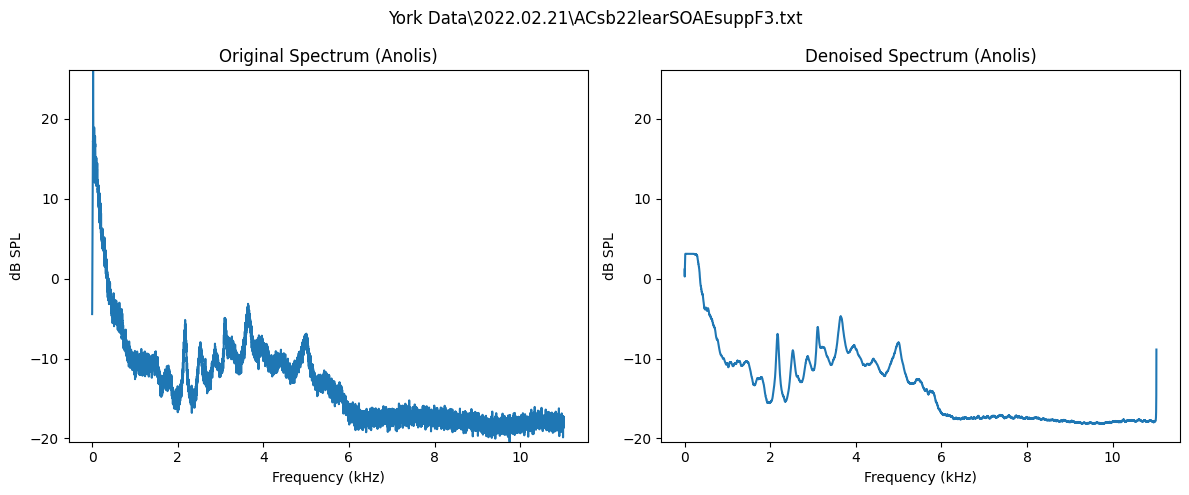

In [87]:
plot_ae_samples("original l2=0.0001", test_df, save=True)

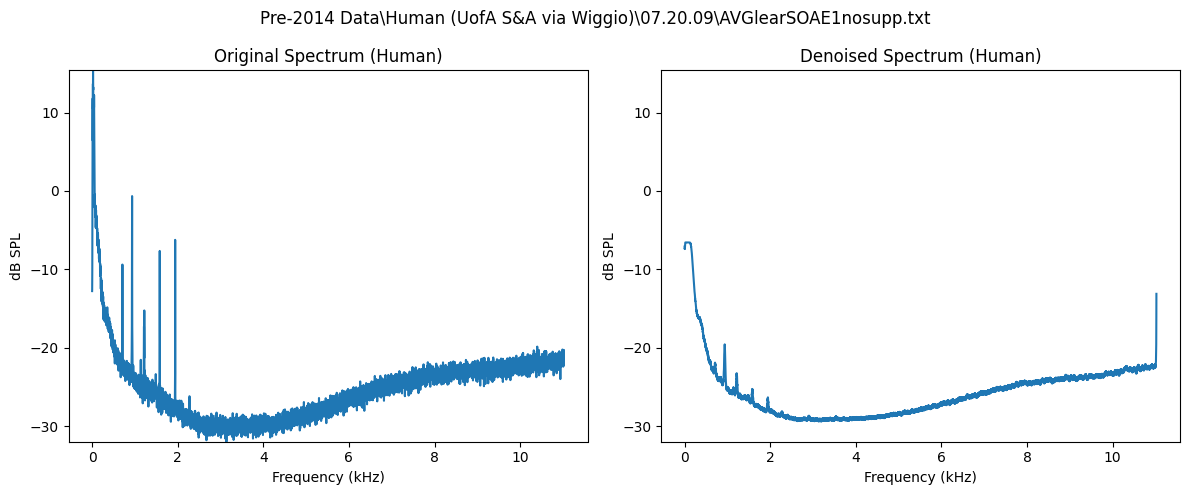

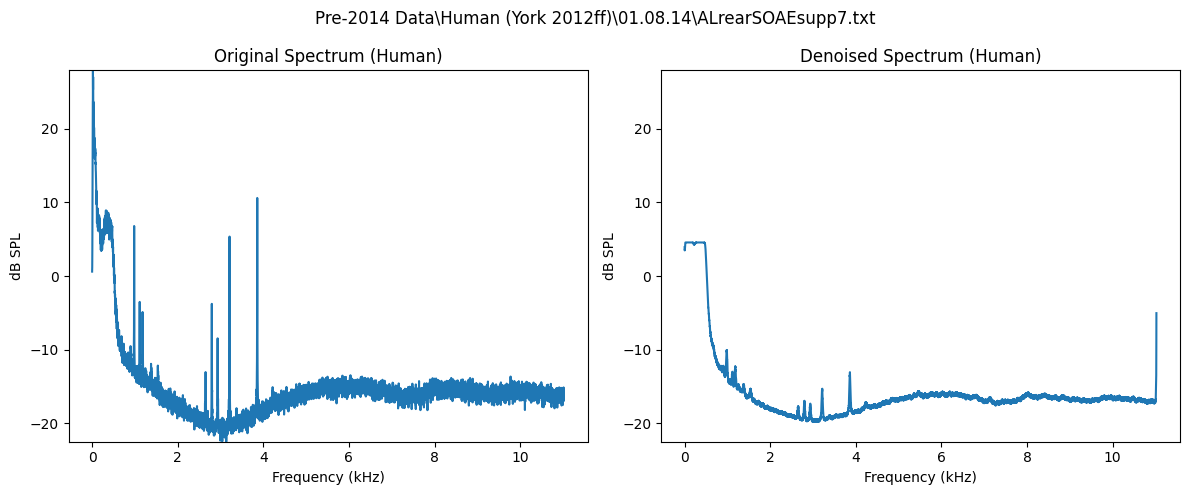

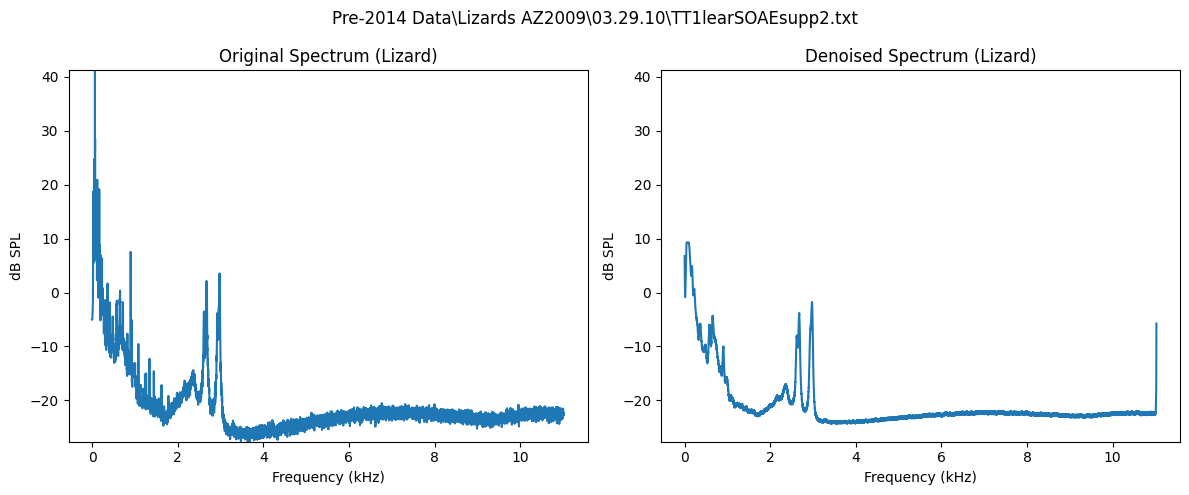

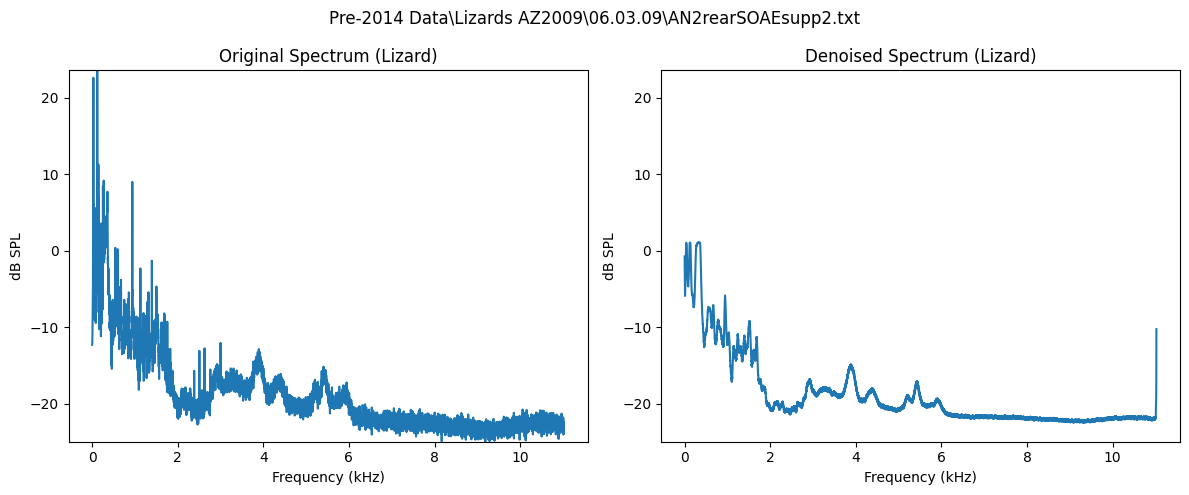

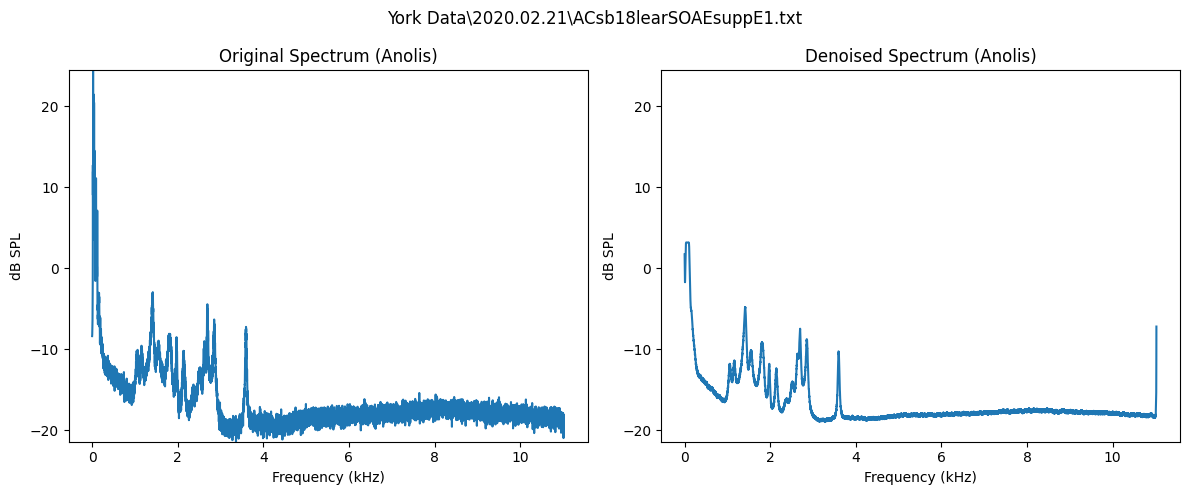

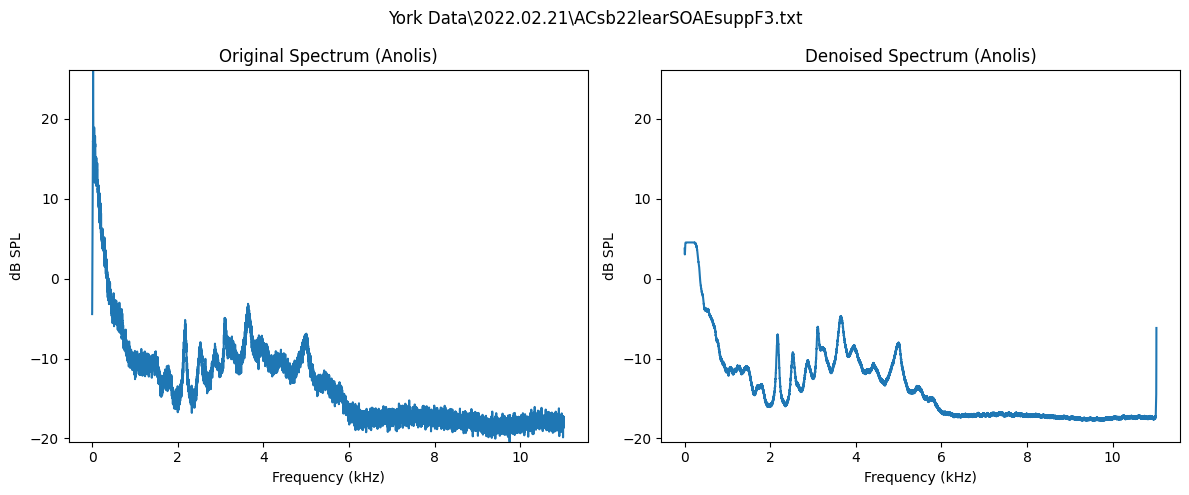

In [88]:
plot_ae_samples("original l2=0.001", test_df, save=True)